# Heart Disease Dataset
This data set dates from 1988 and consists of four databases: Cleveland, Hungary, Switzerland, and Long Beach V. It contains 76 attributes, including the predicted attribute, but all published experiments refer to using a subset of 14 of them. The "target" field refers to the presence of heart disease in the patient. It is integer valued 0 = no disease and 1 = disease.

In [40]:
import ipywidgets
from sklearn.inspection import permutation_importance

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, true_positive_rate,false_positive_rate

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import shap
import numpy as np

In [41]:
#Datei einlesen
df = pd.read_csv("heart3.csv")
df_orginal = df.copy()

In [42]:
#DataFrame-Beispiel Daten
styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.000000,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.000000,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.000000,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.500000,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.000000,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.000000,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.000000,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.000000,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.500000,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.000000,Up,0


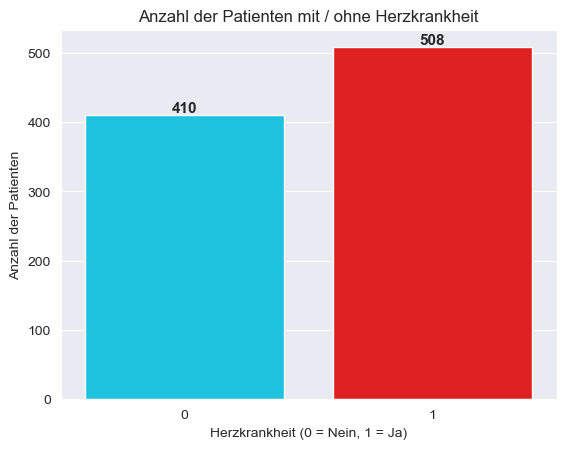

Anzahl der Zeilen (Patienten): 918
Anzahl der Spalten (Features): 12


In [43]:
#Balkendiagramm Anteil Herzerkrankte

# Balkendiagramm
ax = sns.countplot(x='HeartDisease', hue='HeartDisease', data=df, palette=['#00d9ff', '#ff0000'], legend=False)

# Achsentitel
plt.title('Anzahl der Patienten mit / ohne Herzkrankheit')
plt.xlabel('Herzkrankheit (0 = Nein, 1 = Ja)')
plt.ylabel('Anzahl der Patienten')

# Zahlen über Balken schreiben
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold')

# Plot anzeigen
plt.show()
print(f"Anzahl der Zeilen (Patienten): {df.shape[0]}")
print(f"Anzahl der Spalten (Features): {df.shape[1]}")

# Daten Voberarbeitung

## Duplikate & Fehlende Werte

In [44]:

# Alle duplizierten Zeilen (inkl. Erstvorkommen)
duplikate_df = df[df.duplicated(keep=False)]

# Anzahl und Prozent Duplikate
anzahl_duplikate = len(duplikate_df)
gesamt = len(df)
prozent_duplikate = (anzahl_duplikate / gesamt) * 100

# Verteilung HeartDisease in den Duplikaten
verteilung_duplikate = duplikate_df['HeartDisease'].value_counts(normalize=True) * 100

# Verteilung HeartDisease im gesamten DataFrame
verteilung_gesamt = df['HeartDisease'].value_counts(normalize=True) * 100

# Ausgabe
print("Gesamtzeilen:", gesamt)
print("Anzahl mehrfach vorkommender Zeilen:", anzahl_duplikate)
print(f"Prozent mehrfach vorkommend: {prozent_duplikate:.2f}%\n")

print("Verteilung von Heartdisease innerhalb der Duplikate:")
if not verteilung_duplikate.empty:
    for wert, proz in verteilung_duplikate.items():
        print(f"  {wert}: {proz:.2f}%")
else:
    print("    - - -")

print("\nGesamtverteilung HeartDisease:")
for wert, proz in verteilung_gesamt.items():
    print(f"  {wert}: {proz:.2f}%")

Gesamtzeilen: 918
Anzahl mehrfach vorkommender Zeilen: 0
Prozent mehrfach vorkommend: 0.00%

Verteilung von Heartdisease innerhalb der Duplikate:
    - - -

Gesamtverteilung HeartDisease:
  1: 55.34%
  0: 44.66%


In [45]:
# Duplikate entfernen
df = df.drop_duplicates()

In [46]:
# Fehlende Werte prüfen
print(df.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


## Typprüfung
ob Datenentypen zu den bezeichnungen stimmen

In [47]:
def check_values(column_type, valid_values):
    if column_type not in df.columns:
        print(f"Spalte '{column_type}' nicht im Datensatz gefunden.")
        return

    values = df[column_type].dropna().unique()
    invalid = set(values).difference(set(valid_values))
    if invalid:
         print(f" Ungültige Werte in Spalte '{column_type}': {(invalid)} ")
    else:
        print(f"Alle Werte in Spalte '{column_type}' sind gültig ")

valid_values_dict = {
    "Sex": {'M', 'F'},
    "ChestPainType": {'TA', 'ATA', 'NAP', 'ASY'},
    "RestingECG": {'Normal', 'ST', 'LVH'},
    "ExerciseAngina": {'Y', 'N'},
    "ST_Slope": {'Up', 'Flat', 'Down'}
}
def check_if_numeric (column_type, valid_values):
    if column_type not in df.columns:
        print(f"Spalte {column_type}' nicht im Datensatz gefunden.")
        return
    else:
        non_numeric = df[column_type].dropna().apply(lambda x: not isinstance(x, (int, float)))
        if non_numeric.any():
            count_invalid = non_numeric.sum()
            print(f"{count_invalid} nicht numerische Werte in Spalte '{column_type}'")
            print(f"Beispiele: {df[column_type][non_numeric].unique()[:5]}")
        else:
            print(f"Alle Werte in Spalte '{column_type}' sind numerisch.")

numeric_columns = [
    'Age',
    'RestingBP',
    'Cholesterol',
    'FastingBS',
    'MaxHR',
    'Oldpeak',
    'HeartDisease'
]
# Anwendung:
for column, valid_set in valid_values_dict.items():
    check_values(column, valid_set)

for col in numeric_columns:
    check_if_numeric(col, numeric_columns)

Alle Werte in Spalte 'Sex' sind gültig 
Alle Werte in Spalte 'ChestPainType' sind gültig 
Alle Werte in Spalte 'RestingECG' sind gültig 
Alle Werte in Spalte 'ExerciseAngina' sind gültig 
Alle Werte in Spalte 'ST_Slope' sind gültig 
Alle Werte in Spalte 'Age' sind numerisch.
Alle Werte in Spalte 'RestingBP' sind numerisch.
Alle Werte in Spalte 'Cholesterol' sind numerisch.
Alle Werte in Spalte 'FastingBS' sind numerisch.
Alle Werte in Spalte 'MaxHR' sind numerisch.
Alle Werte in Spalte 'Oldpeak' sind numerisch.
Alle Werte in Spalte 'HeartDisease' sind numerisch.


## Unrealistische Werte

In [48]:
limits = {
    'Age': (0, 120),
    'RestingBP': (40, 150),
    'Cholesterol': (1, 800),
    'MaxHR': (60, 202),
    'Oldpeak': (0, 5)
}

print(f"Anzahl an Zeilen (vorher): {len(df)}")

def show_outliers(limits_dict):
    for col, (min_val, max_val) in limits_dict.items():
        invalid = df[(df[col] < min_val) | (df[col] > max_val)][col]
        print(f"{col}: {len(invalid)} Werte außerhalb ({min_val}–{max_val})")
        if not invalid.empty:
            print(f"    Beispiele: {invalid.unique()[:5]}")

def clip_outliers(limits_dict):
    df_clipped = df.copy()
    for col, (min_val, max_val) in limits_dict.items():
        before = df_clipped[col]
        df_clipped[col] = before.clip(lower=min_val, upper=max_val)
    print("\nClipping angewenden:")
    show_outliers(limits)
    return df_clipped

show_outliers(limits)
df = clip_outliers(limits)
print(f"\nNeue Anzahl an Zeilen (nach Filter): {len(df)}")

Anzahl an Zeilen (vorher): 918
Age: 0 Werte außerhalb (0–120)
RestingBP: 118 Werte außerhalb (40–150)
    Beispiele: [160 170 190 180 155]
Cholesterol: 172 Werte außerhalb (1–800)
    Beispiele: [0]
MaxHR: 0 Werte außerhalb (60–202)
Oldpeak: 15 Werte außerhalb (0–5)
    Beispiele: [-0.9 -2.6 -1.5 -0.1 -1. ]

Clipping angewenden:
Age: 0 Werte außerhalb (0–120)
RestingBP: 118 Werte außerhalb (40–150)
    Beispiele: [160 170 190 180 155]
Cholesterol: 172 Werte außerhalb (1–800)
    Beispiele: [0]
MaxHR: 0 Werte außerhalb (60–202)
Oldpeak: 15 Werte außerhalb (0–5)
    Beispiele: [-0.9 -2.6 -1.5 -0.1 -1. ]

Neue Anzahl an Zeilen (nach Filter): 918


## Bias/Korrelation

Altersverteilung 
count    918.000000
mean      53.510893
std        9.432617
min       28.000000
25%       47.000000
50%       54.000000
75%       60.000000
max       77.000000
Name: Age, dtype: float64


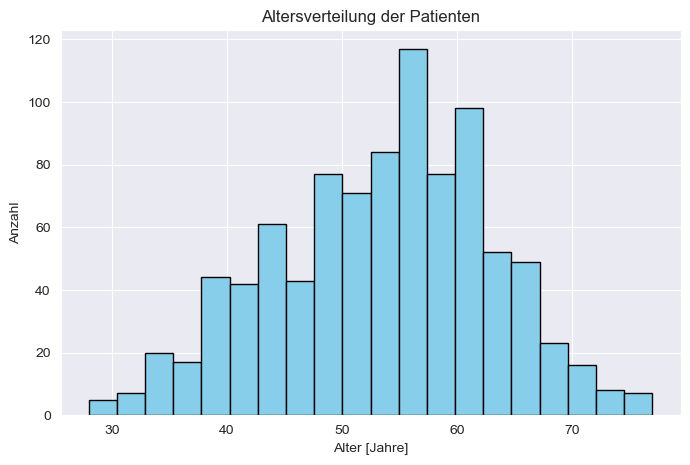

In [49]:
print("Altersverteilung ")
print(df['Age'].describe())

plt.figure(figsize=(8,5))
plt.hist(df['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Altersverteilung der Patienten')
plt.xlabel('Alter [Jahre]')
plt.ylabel('Anzahl')
plt.show()

 Geschlechterverteilung 
M: 725 Patienten (78.98%)
F: 193 Patienten (21.02%)


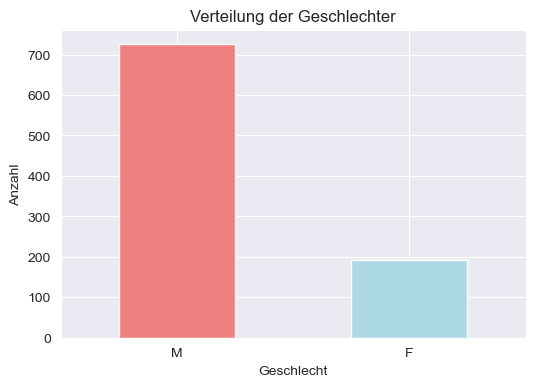

In [50]:
print(" Geschlechterverteilung ")
gender_counts = df['Sex'].value_counts()
gender_percent = df['Sex'].value_counts(normalize=True) * 100

for sex in gender_counts.index:
    print(f"{sex}: {gender_counts[sex]} Patienten ({gender_percent[sex]:.2f}%)")

plt.figure(figsize=(6,4))
gender_counts.plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Verteilung der Geschlechter')
plt.xlabel('Geschlecht')
plt.ylabel('Anzahl')
plt.xticks(rotation=0)
plt.show()


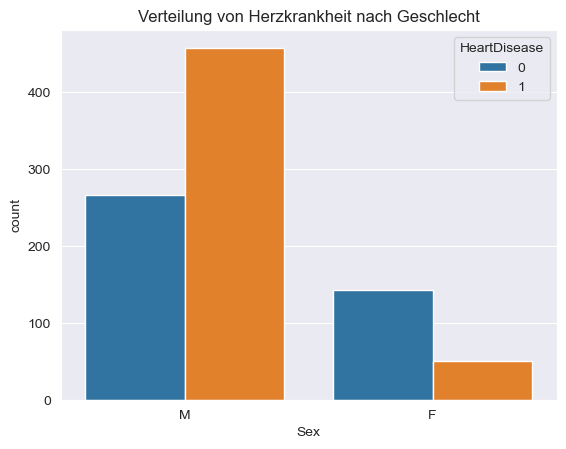

Sex
F    0.259067
M    0.631724
Name: HeartDisease, dtype: float64


In [51]:
# Bias: Zielverteilung nach Geschlecht
sns.countplot(data=df, x='Sex', hue='HeartDisease')
plt.title("Verteilung von Herzkrankheit nach Geschlecht")
plt.show()

# Diagnosewahrscheinlichkeit pro Geschlecht
print(df.groupby("Sex")["HeartDisease"].mean())

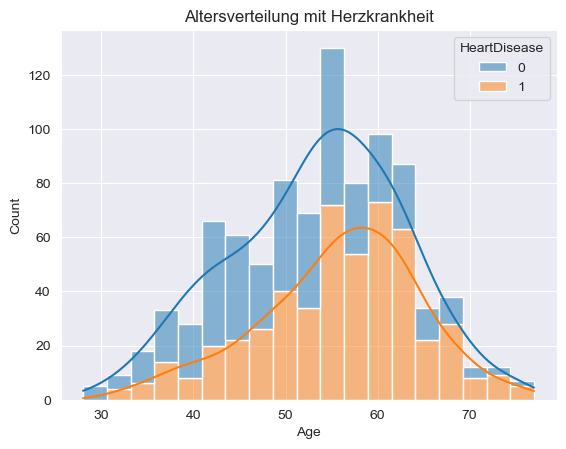

Age_cat
20–30    0.000000
31–40    0.363636
41–50    0.417040
51–60    0.582677
61–80    0.728507
Name: HeartDisease, dtype: float64


In [52]:
#Bias: Altersverteilung mit/ohne Herzkrankheit
sns.histplot(data=df, x='Age', hue='HeartDisease', kde=True, multiple='stack')
plt.title("Altersverteilung mit Herzkrankheit")
plt.show()

# Altersgruppenbildung für Analyse
df['Age_cat'] = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60, 80],
                        labels=["20–30", "31–40", "41–50", "51–60", "61–80"])
print(df.groupby("Age_cat", observed=True)["HeartDisease"].mean())


In [53]:
# Anteil Herzkrankheiten bei Fasting Blood Sugar hoch/niedrig
print(df.groupby("FastingBS")["HeartDisease"].mean())

FastingBS
0    0.480114
1    0.794393
Name: HeartDisease, dtype: float64


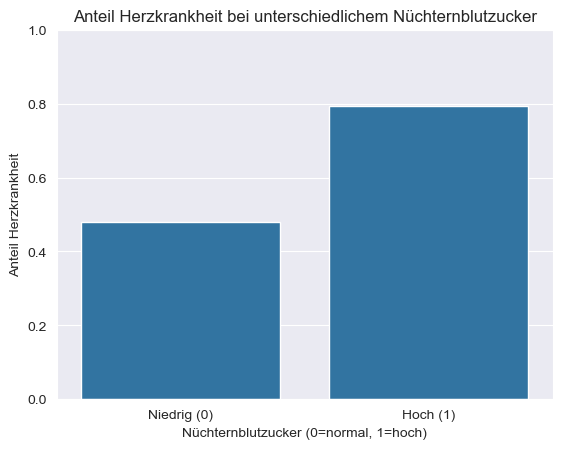

FastingBS
0    0.480114
1    0.794393
Name: HeartDisease, dtype: float64


In [54]:
# Anteil Herzkrankheiten pro Nüchternblutzucker
heart_disease_rate = df.groupby("FastingBS")["HeartDisease"].mean().reset_index()

# Plot mit Seaborn
sns.barplot(data=heart_disease_rate, x="FastingBS", y="HeartDisease")

plt.xticks([0, 1], ['Niedrig (0)', 'Hoch (1)'])
plt.ylabel("Anteil Herzkrankheit")
plt.xlabel("Nüchternblutzucker (0=normal, 1=hoch)")
plt.title("Anteil Herzkrankheit bei unterschiedlichem Nüchternblutzucker")
plt.ylim(0, 1)  # y-Achse von 0 bis 1
plt.show()

print(df.groupby("FastingBS")["HeartDisease"].mean())

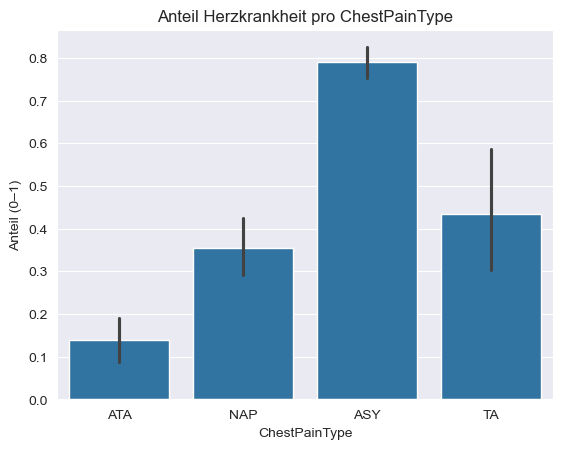

Anteil an Herzkrankheiten (%) pro ChestPainType:

ChestPainType
ASY    79.03
TA     43.48
NAP    35.47
ATA    13.87
Name: HeartDisease, dtype: float64


In [55]:
# Kreuztabelle: Anzahl Herzkrankheiten pro ChestPainType
#pd.crosstab(df['ChestPainType'], df['HeartDisease'], normalize='index') * 100

#  Anteil Herzkrankheit je ChestPainType
sns.barplot(
    data=df,
    x='ChestPainType',
    y='HeartDisease',
    estimator=lambda x: sum(x) / len(x)  # Mittelwert = Anteil Herzkrankheit
)
plt.title("Anteil Herzkrankheit pro ChestPainType")
plt.ylabel("Anteil (0–1)")
plt.show()

# Prozentsatz Herzkrankheit pro ChestPainType
heart_disease_by_cp = df.groupby("ChestPainType")["HeartDisease"].mean().sort_values(ascending=False) * 100

print("Anteil an Herzkrankheiten (%) pro ChestPainType:\n")
print(heart_disease_by_cp.round(2))

In [56]:
# Feature Engineering

# Resting BP
def restingBP_categorization(bp):
    if bp < 120:
        return 100
    elif 120<= bp <= 129:
        return 125
    elif 130<= bp <= 139:
        return 135
    elif 140<= bp <= 179:
        return 160
    else: return 190

df['RestingBP'] = df['RestingBP'].apply(restingBP_categorization)

def cholesterol_category_by_age(row):
    age = row['Age']
    sex = row['Sex']
    chol = row['Cholesterol']

    # Wertebereiche laut Tabelle (vereinfacht)
    if sex == 'M':  # Männer
        if age < 40:
            min_val, max_val = 150, 220
        elif age < 50:
            min_val, max_val = 160, 240
        elif age < 60:
            min_val, max_val = 170, 240
        else:
            min_val, max_val = 175, 240
    else:  # Frauen
        if age < 40:
            min_val, max_val = 150, 240
        elif age < 50:
            min_val, max_val = 160, 240
        elif age < 60:
            min_val, max_val = 170, 260
        else:
            min_val, max_val = 195, 270

    if chol < min_val:
        return 0
    elif chol > max_val:
        return 1
    else:
        return 0.5

df['Cholesterol_cat_age'] = df.apply(cholesterol_category_by_age, axis=1)

# Max HR
def maxhr_age_category(row):
    maxhr = row['MaxHR']
    age = row['Age']
    expected_maxhr = 220 - age

    if maxhr < 0.7 * expected_maxhr:
        return 1
    elif 0.7 * expected_maxhr <= maxhr <= expected_maxhr:
        return 2
    elif expected_maxhr < maxhr <= 1.1 * expected_maxhr:
        return 3
    else:
        return 4

df['MaxHR'] = df.apply(maxhr_age_category, axis=1)


def age_category(age_group):
    if age_group == '20–30':
        return 25
    elif age_group == '31–40':
        return 36
    elif age_group == '41–50':
        return 46
    elif age_group == '51–60':
        return 56
    elif age_group == '61–80':
        return 70
    else:
        return 0

df['Age_cat'] = df['Age_cat'].apply(age_category)

#One Hot Encoding bei Nominalen Kategorien
df = pd.get_dummies(df, columns=["ChestPainType", "RestingECG", "ST_Slope"], drop_first=True, dtype=int)

# Mapping für Sex (Männlich = 1, Weiblich = 0)
df["Sex"] = df["Sex"].map({'M': 1, 'F': 0})

# Mapping für ExerciseAngina (Ja = 1, Nein = 0)
df["ExerciseAngina"] = df["ExerciseAngina"].map({'Y': 1, 'N': 0})

styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,Age_cat,Cholesterol_cat_age,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,40,1,160,289,0,2,0,0.000000,0,36,1.000000,1,0,0,1,0,0,1
1,49,0,160,180,0,2,0,1.000000,1,46,0.500000,0,1,0,1,0,1,0
2,37,1,135,283,0,1,0,0.000000,0,36,1.000000,1,0,0,0,1,0,1
3,48,0,135,214,0,1,1,1.500000,1,46,0.500000,0,0,0,1,0,1,0
4,54,1,160,195,0,2,0,0.000000,0,56,0.500000,0,1,0,1,0,0,1
5,39,1,125,339,0,2,0,0.000000,0,36,1.000000,0,1,0,1,0,0,1
6,45,0,135,237,0,2,0,0.000000,0,46,0.500000,1,0,0,1,0,0,1
7,54,1,100,208,0,2,0,0.000000,0,56,0.500000,1,0,0,1,0,0,1
8,37,1,160,207,0,2,1,1.500000,1,36,0.500000,0,0,0,1,0,1,0
9,48,0,125,284,0,1,0,0.000000,0,46,1.000000,1,0,0,1,0,0,1


In [57]:
#Skalieren
scaler = MinMaxScaler()
scale_cols = ["RestingBP", "Cholesterol", "MaxHR", "ExerciseAngina", "Oldpeak", "Age_cat"]

df[scale_cols] = scaler.fit_transform(df[scale_cols])

styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,Age_cat,Cholesterol_cat_age,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,40,1,1.000000,0.478405,0,0.333333,0.000000,0.000000,0,0.244444,1.000000,1,0,0,1,0,0,1
1,49,0,1.000000,0.297342,0,0.333333,0.000000,0.200000,1,0.466667,0.500000,0,1,0,1,0,1,0
2,37,1,0.583333,0.468439,0,0.000000,0.000000,0.000000,0,0.244444,1.000000,1,0,0,0,1,0,1
3,48,0,0.583333,0.353821,0,0.000000,1.000000,0.300000,1,0.466667,0.500000,0,0,0,1,0,1,0
4,54,1,1.000000,0.322259,0,0.333333,0.000000,0.000000,0,0.688889,0.500000,0,1,0,1,0,0,1
5,39,1,0.416667,0.561462,0,0.333333,0.000000,0.000000,0,0.244444,1.000000,0,1,0,1,0,0,1
6,45,0,0.583333,0.392027,0,0.333333,0.000000,0.000000,0,0.466667,0.500000,1,0,0,1,0,0,1
7,54,1,0.000000,0.343854,0,0.333333,0.000000,0.000000,0,0.688889,0.500000,1,0,0,1,0,0,1
8,37,1,1.000000,0.342193,0,0.333333,1.000000,0.300000,1,0.244444,0.500000,0,0,0,1,0,1,0
9,48,0,0.416667,0.470100,0,0.000000,0.000000,0.000000,0,0.466667,1.000000,1,0,0,1,0,0,1


# Machine Learning

In [58]:
# Train Test Split für RF, LR, Stacking

# 1. Daten vorbereiten: Heartdisease spalte und alte age Spalte entfernen
X = df.drop(columns=['HeartDisease', 'Age', 'Cholesterol'])
y = df['HeartDisease']

# 2. Trainings-/Testdaten Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Random Forrest

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Beste Parameterkombination (grid_search.best_params_):
  bootstrap: True
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 5
  n_estimators: 200

Bester CV-Score (grid_search.best_score_): 0.8691


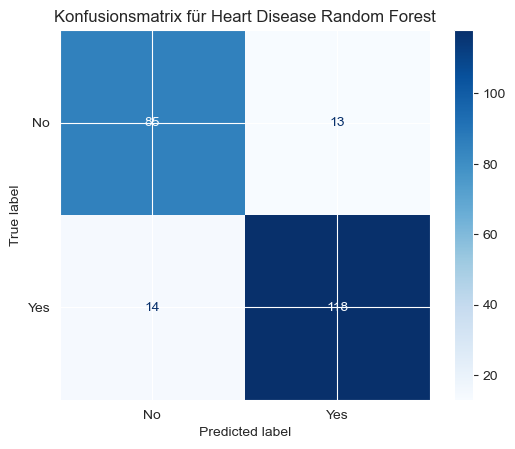

Genauigkeit: 0.8826086956521739

Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.820513   0.636364  0.700000  0.666667        0.282051
1    0.895288   0.925000  0.909836  0.917355        0.628272
Demographic Parity Difference: 0.346


In [59]:
#Random Forest mit Gridsearch

# 3. Parametergrid für rf
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# 4. Random Forest mit GridSearchCV
rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)

# 5. Beste Parameter und beste Score ausgeben
print("Beste Parameterkombination (grid_search.best_params_):")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBester CV-Score (grid_search.best_score_): {grid_search.best_score_:.4f}")
# 6. Modell evaluieren
best_model = grid_search.best_estimator_
y_pred_rand = best_model.predict(X_test)

#7. Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Random Forest')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Genauigkeit:", accuracy)

#8. Fairness-Analyse nach Geschlecht
# Sensitives Merkmal extrahieren (Sex)
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

# MetricFrame mit Gruppenvergleich
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


### RF mit Balanced

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Beste Parameterkombination (grid_search.best_params_):
  bootstrap: True
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 200

Bester CV-Score (grid_search.best_score_): 0.8735


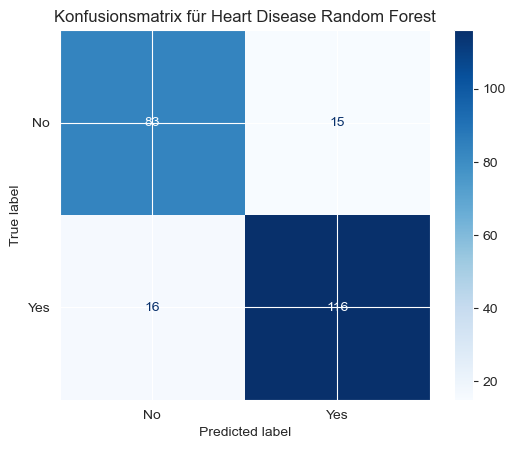

Genauigkeit: 0.8652173913043478

Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.794872   0.583333  0.700000  0.636364        0.307692
1    0.879581   0.915966  0.893443  0.904564        0.623037
Demographic Parity Difference: 0.315


In [60]:
#Random Forest mit Gridsearch BALANCED
# 3. Parametergrid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# 4. Random Forest mit GridSearchCV + balanced
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)

# 5. Beste Parameter und beste Score ausgeben
print("Beste Parameterkombination (grid_search.best_params_):")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBester CV-Score (grid_search.best_score_): {grid_search.best_score_:.4f}")
# 6. Modell evaluieren
best_model = grid_search.best_estimator_
y_pred_rand = best_model.predict(X_test)

#7. Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Random Forest')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Genauigkeit:", accuracy)

#8. Fairness-Analyse nach Geschlecht
# Sensitives Merkmal extrahieren (Sex)
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

# MetricFrame mit Gruppenvergleich
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


### Top 10 RF Merkmale

ST_Slope_Up: 0.0400 ± 0.0139
ST_Slope_Flat: 0.0322 ± 0.0156
Cholesterol_cat_age: 0.0304 ± 0.0058
Oldpeak: 0.0191 ± 0.0103
FastingBS: 0.0183 ± 0.0051
Sex: 0.0126 ± 0.0066
ExerciseAngina: 0.0070 ± 0.0087
ChestPainType_ATA: 0.0061 ± 0.0062
Age_cat: 0.0057 ± 0.0052
RestingBP: 0.0057 ± 0.0073


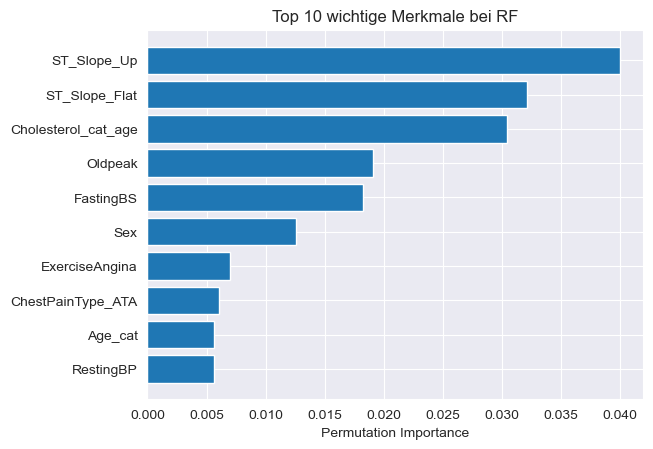

In [61]:
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Sortieren der Features nach Wichtigkeit
sorted_idx = result.importances_mean.argsort()[::-1]
for i in sorted_idx[:10]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

#Plot

plt.barh(X_test.columns[sorted_idx[:10]][::-1], result.importances_mean[sorted_idx[:10]][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top 10 wichtige Merkmale bei RF")
plt.show()

### Analyse mit SHAP

In [62]:
shap.initjs()

#SHAP-Explainer mit Trainingsdaten initialisieren (nur Features!)
explainer = shap.Explainer(best_model, X_train)

#SHAP-Werte für Testdaten berechnen
shap_values = explainer(X_test, check_additivity=False)

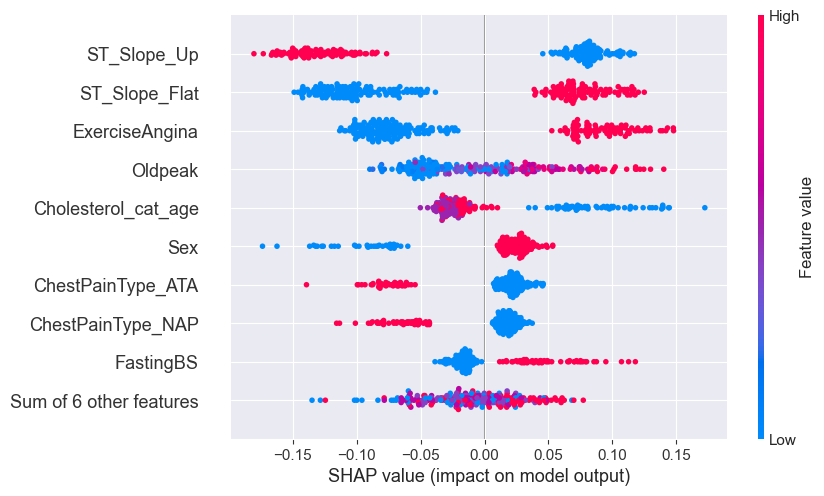

In [63]:
# Wichtigste Features für Klasse 1 ("krank")
shap.plots.beeswarm(shap_values[:, :, 1])

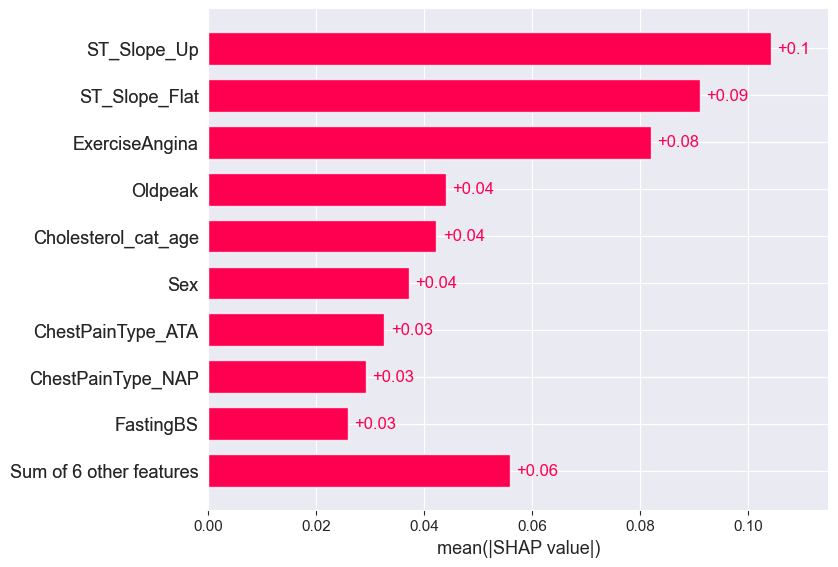

In [64]:
#Bar-Plot der wichtigsten Merkmale
shap.plots.bar(shap_values[:, :, 1])

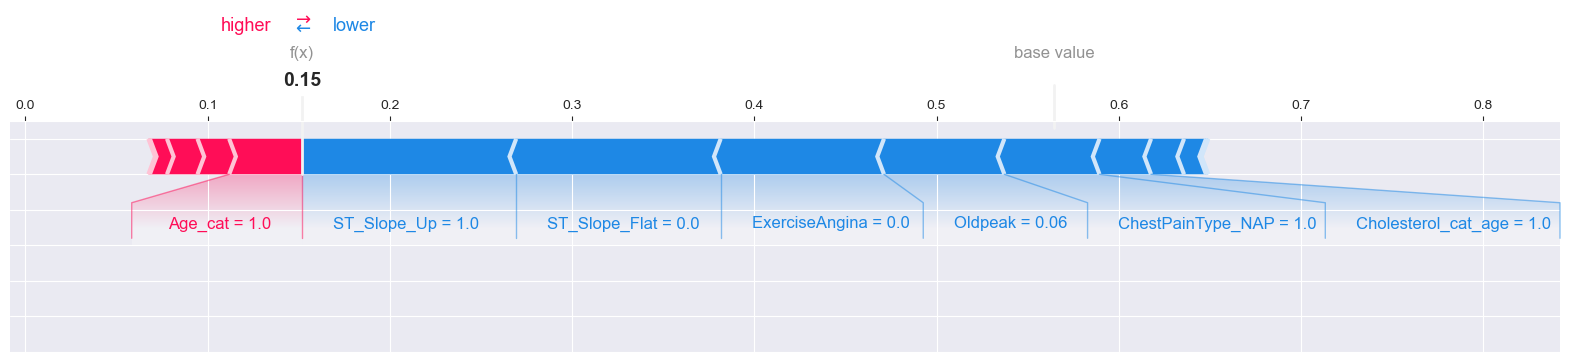

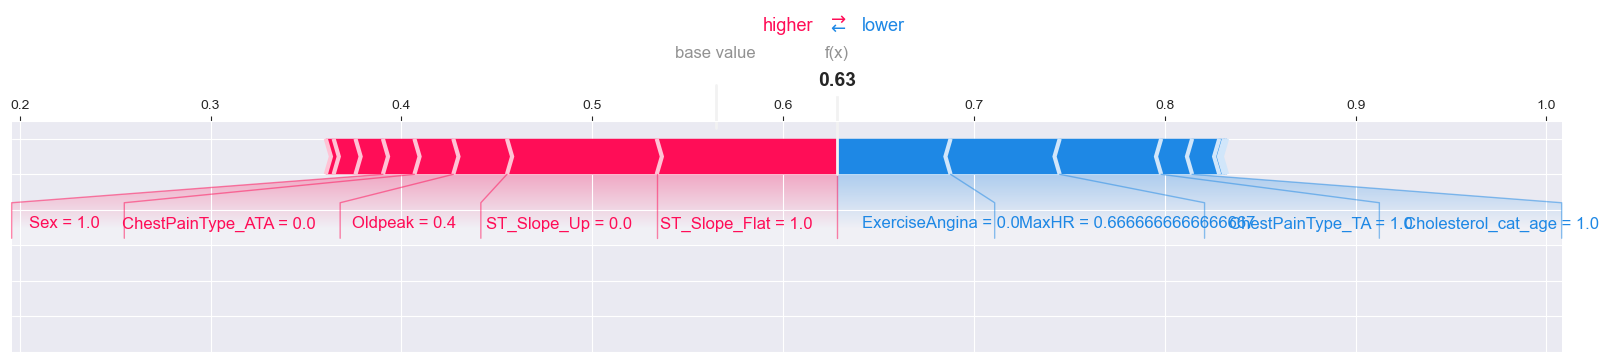

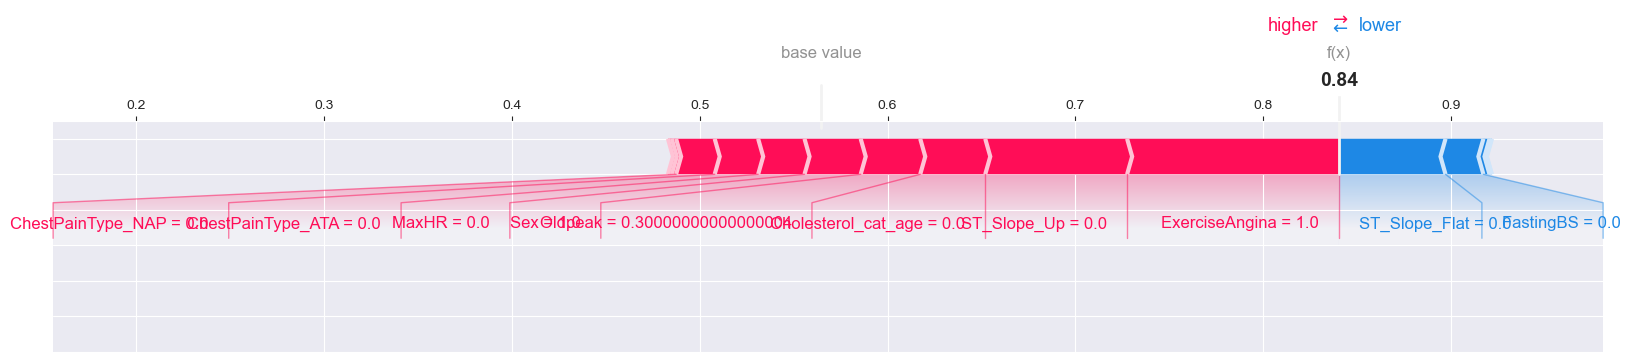

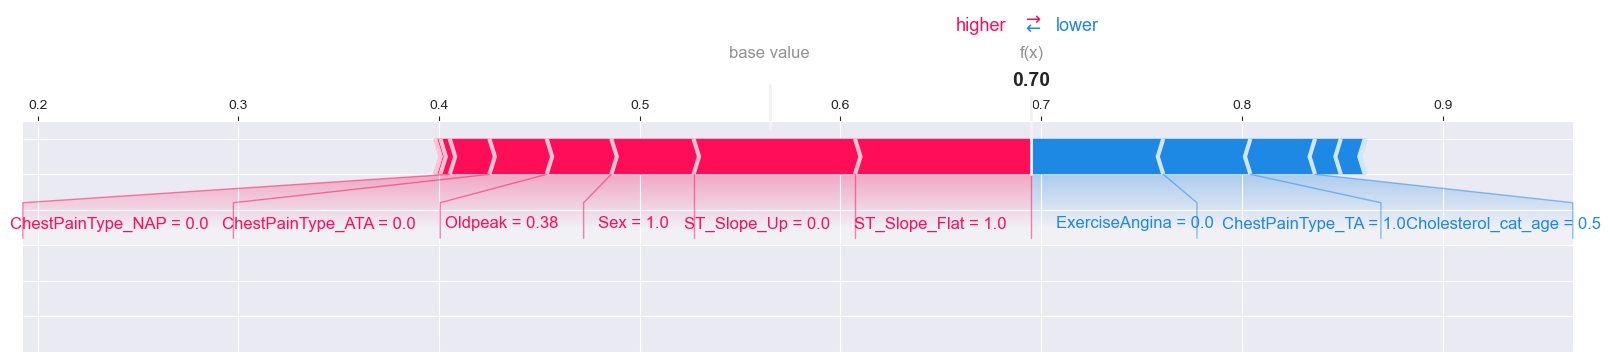

In [65]:
# Einzelen Datenpunkter analysieren
indices = [7, 8, 9, 10]

for i, index in enumerate(indices):
    shap.plots.force(shap_values[index, :, 1], matplotlib=True)

## Logistic Regression Balanced

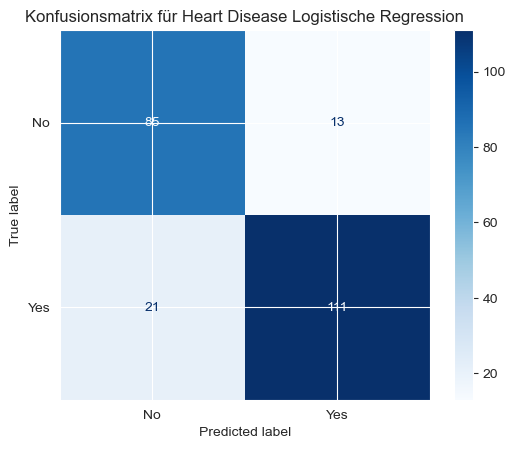

Genauigkeit: 0.8521739130434782
Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.743590   0.500000  0.500000  0.500000        0.256410
1    0.874346   0.929825  0.868852  0.898305        0.596859
Demographic Parity Difference: 0.340


In [66]:
#logisticRegeression balanced
modelLogistic = LogisticRegression(max_iter=1000,class_weight='balanced')
modelLogistic.fit(X_train, y_train)

y_pred = modelLogistic.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Logistische Regression')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print("Genauigkeit:", accuracy)

#Fariness:

# Sensitives Merkmal extrahieren (Sex)
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

# MetricFrame mit Gruppenvergleich
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)

print("Fairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


### Top 10 LR Merkmale

FastingBS: 0.0261 ± 0.0085
ChestPainType_ATA: 0.0209 ± 0.0134
ChestPainType_NAP: 0.0170 ± 0.0100
Cholesterol_cat_age: 0.0130 ± 0.0089
ST_Slope_Flat: 0.0096 ± 0.0097
Sex: 0.0091 ± 0.0081
ST_Slope_Up: 0.0065 ± 0.0115
ChestPainType_TA: 0.0057 ± 0.0058
ExerciseAngina: 0.0039 ± 0.0121
Oldpeak: 0.0004 ± 0.0057


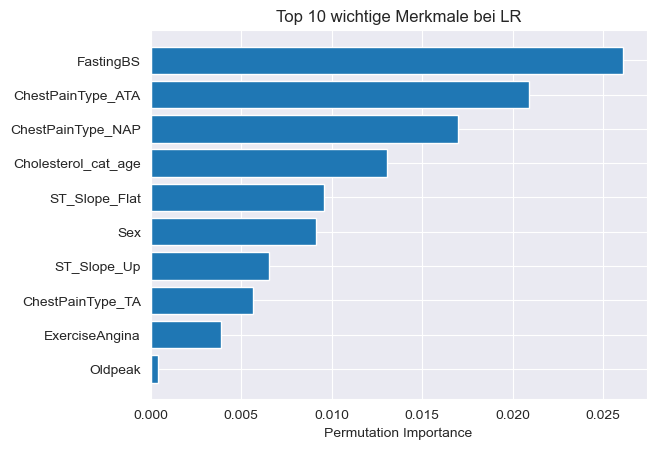

In [67]:
result = permutation_importance(modelLogistic, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Sortieren der Features nach Wichtigkeit
sorted_idx = result.importances_mean.argsort()[::-1]
for i in sorted_idx[:10]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

#Plot

plt.barh(X_test.columns[sorted_idx[:10]][::-1], result.importances_mean[sorted_idx[:10]][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top 10 wichtige Merkmale bei LR")
plt.show()

### SHAP Analyse

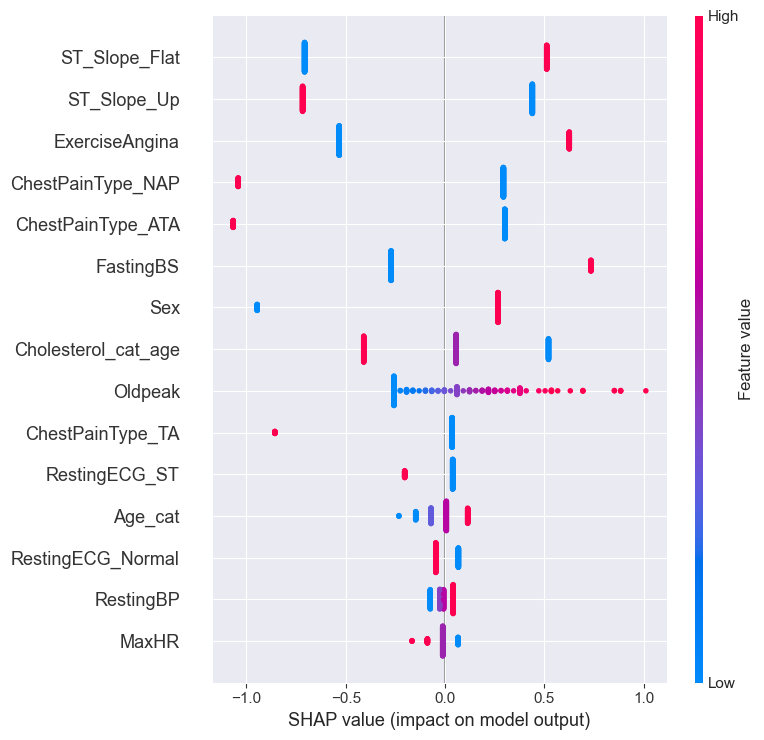

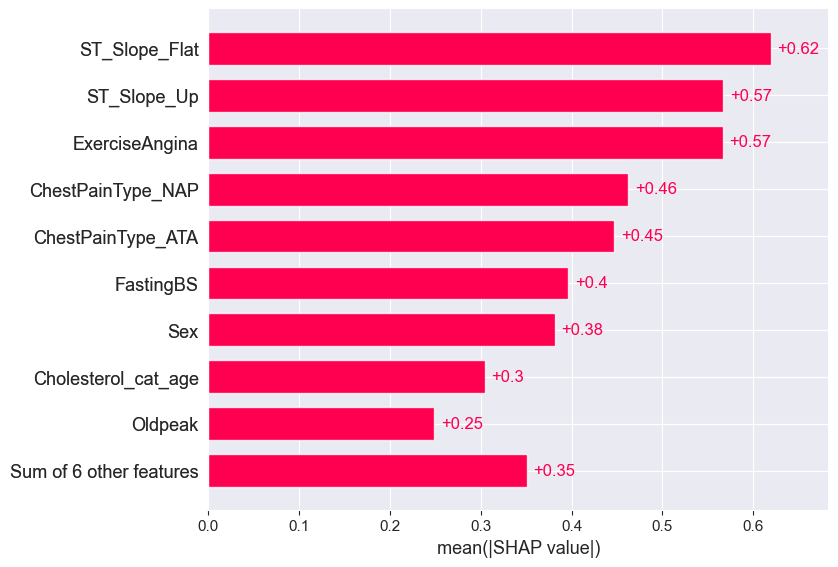

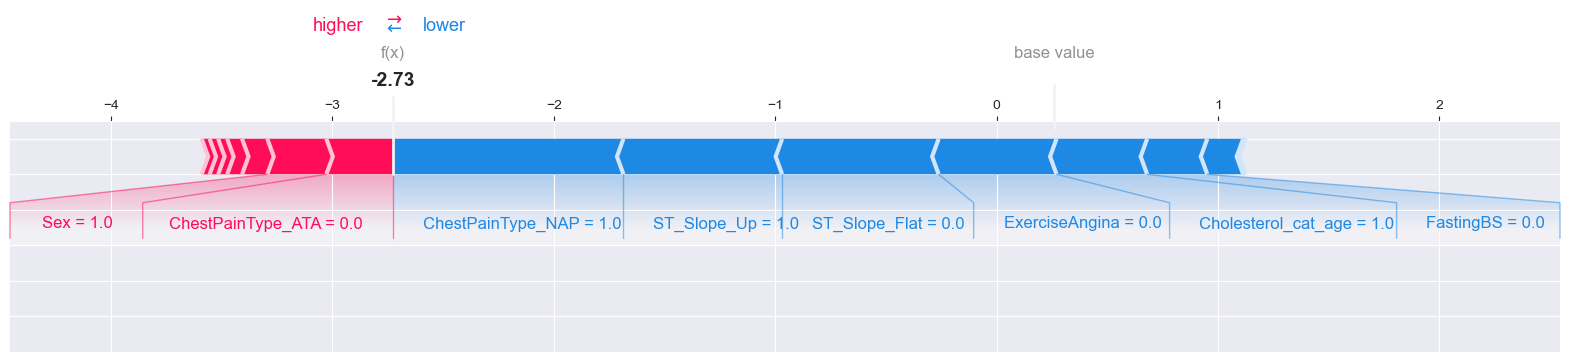

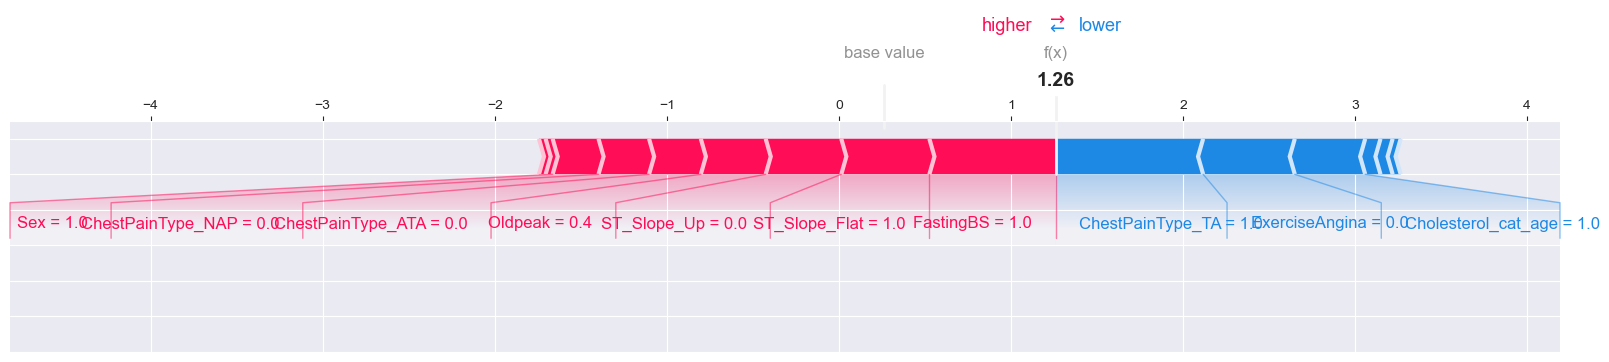

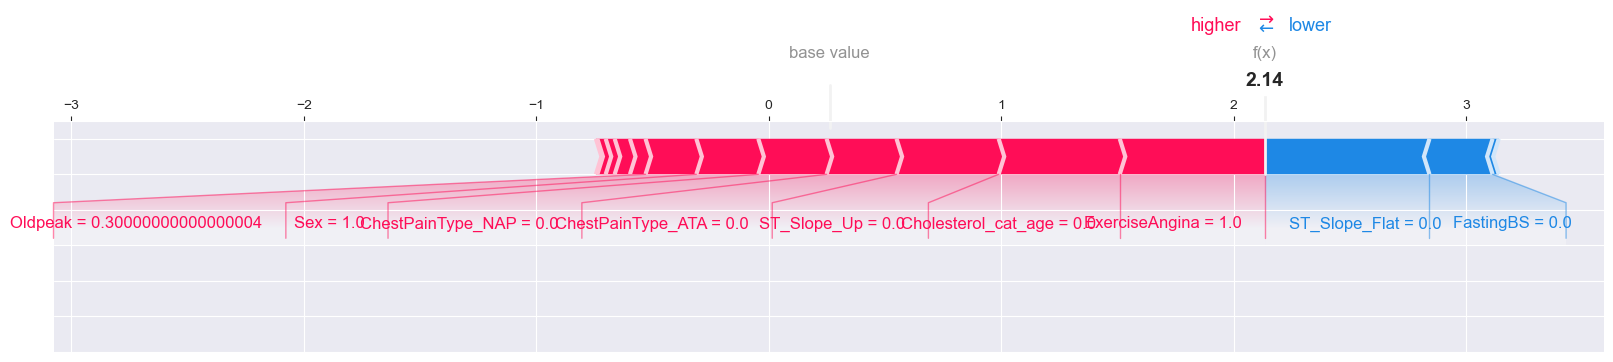

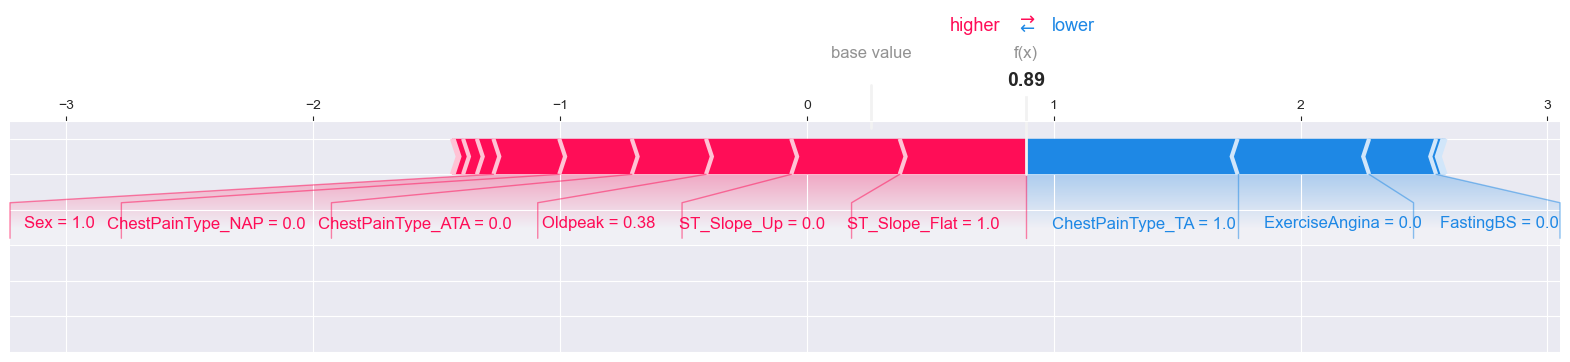

In [68]:
# Neues SHAP-Explainer-Objekt (automatisch korrekt für LogisticRegression)
explainer = shap.Explainer(modelLogistic, X_train)

# SHAP-Werte berechnen – liefert ein Explanation-Objekt
shap_values = explainer(X_test)

# Summary Plot (wichtigste Merkmale)
shap.summary_plot(shap_values, X_test)

# Bar-Plot der durchschnittlichen Wichtigkeit
shap.plots.bar(shap_values)

# Einzelne Datenpunkte analysieren
indices = [7, 8, 9, 10]
for index in indices:
    shap.plots.force(shap_values[index], matplotlib=True)

## Frauen Oversampled

In [69]:
# 3. Oversampling von Frauen im Trainingsteil
train_df = X_train.copy()
train_df["HeartDisease"] = y_train

# Get Frauen (Sex == 0) und Männer
women = train_df[train_df["Sex"] == 0]
men = train_df[train_df["Sex"] == 1]

# Frauen duplizieren, bis gleiche Anzahl wie Männer
women_oversampled = women.sample(n=len(men), replace=True, random_state=42)

# Kombinieren
train_f_oversampled = pd.concat([men, women_oversampled])
X_train_f_oversampled = train_f_oversampled.drop(columns="HeartDisease")
y_train_f_oversampled = train_f_oversampled["HeartDisease"]

### Random Forrest

Neue Verteilung im Training:
Sex
1    534
0    534
Name: count, dtype: int64
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Beste Parameterkombination (grid_search.best_params_):
  bootstrap: True
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 100

Bester CV-Score (grid_search.best_score_): 0.9074


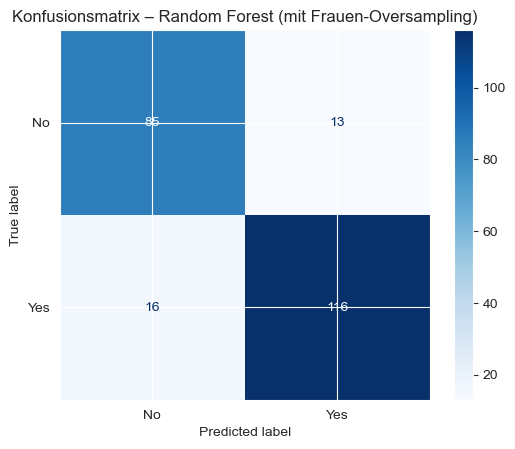

Genauigkeit: 0.8739130434782608

 Predictive Parity (Female): 0.636
 Predictive Parity (Male):   0.924
 Predictive Parity Difference: 0.287

Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate  \
Sex                                                            
0    0.820513   0.636364  0.700000  0.666667        0.282051   
1    0.884817   0.923729  0.893443  0.908333        0.617801   

     false_positive_rate  true_positive_rate  
Sex                                           
0               0.137931            0.700000  
1               0.130435            0.893443  
Demographic Parity Difference: 0.336


In [70]:
print(f"Neue Verteilung im Training:\n{X_train_f_oversampled['Sex'].value_counts()}")

# 4. Parametergrid
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# 5. GridSearchCV
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train_f_oversampled, y_train_f_oversampled)
best_forest_model = grid_search.best_estimator_

# 6. Bestes Modell
print("Beste Parameterkombination (grid_search.best_params_):")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBester CV-Score (grid_search.best_score_): {grid_search.best_score_:.4f}")

# 7. Vorhersage & Evaluation
y_pred_rand = best_forest_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix – Random Forest (mit Frauen-Oversampling)')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Genauigkeit:", accuracy)

#Konfusionsmatrix nach mann und frau
# True-Labels und Vorhersagen für jede Gruppe extrahieren
y_true_female = y_test[sensitive_feature == 0]
y_pred_female = y_pred_rand[sensitive_feature == 0]

y_true_male = y_test[sensitive_feature == 1]
y_pred_male = y_pred_rand[sensitive_feature == 1]

# Precision (predictive parity) für beide Gruppen
precision_female = precision_score(y_true_female, y_pred_female)
precision_male = precision_score(y_true_male, y_pred_male)

# Predictive Parity Difference berechnen
pp_diff = abs(precision_female - precision_male)

print(f"\n Predictive Parity (Female): {precision_female:.3f}")
print(f" Predictive Parity (Male):   {precision_male:.3f}")
print(f" Predictive Parity Difference: {pp_diff:.3f}")

# 8. Fairness-Analyse
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "true_positive_rate": true_positive_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")

### Top 10 Random Forrest Merkmale

ST_Slope_Up: 0.0352 ± 0.0169
Cholesterol_cat_age: 0.0343 ± 0.0060
ST_Slope_Flat: 0.0317 ± 0.0179
Oldpeak: 0.0304 ± 0.0097
ChestPainType_ATA: 0.0296 ± 0.0072
FastingBS: 0.0270 ± 0.0058
Sex: 0.0239 ± 0.0065
ChestPainType_NAP: 0.0183 ± 0.0087
ExerciseAngina: 0.0148 ± 0.0101
ChestPainType_TA: 0.0100 ± 0.0028


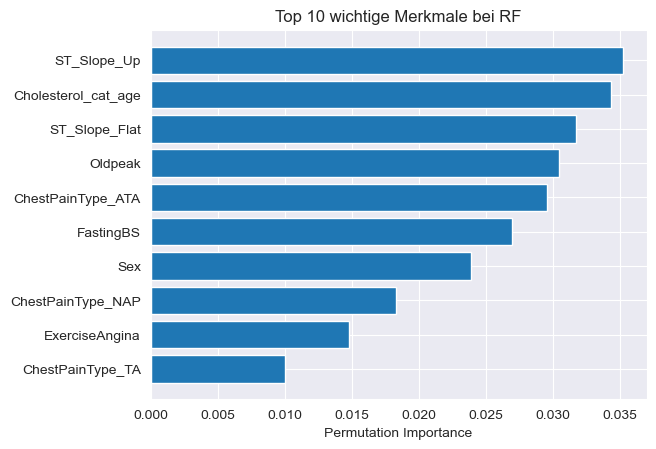

In [71]:
result = permutation_importance(best_forest_model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Sortieren der Features nach Wichtigkeit
sorted_idx = result.importances_mean.argsort()[::-1]
for i in sorted_idx[:10]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

#Plot

plt.barh(X_test.columns[sorted_idx[:10]][::-1], result.importances_mean[sorted_idx[:10]][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top 10 wichtige Merkmale bei RF")
plt.show()

### SHAP Analyse

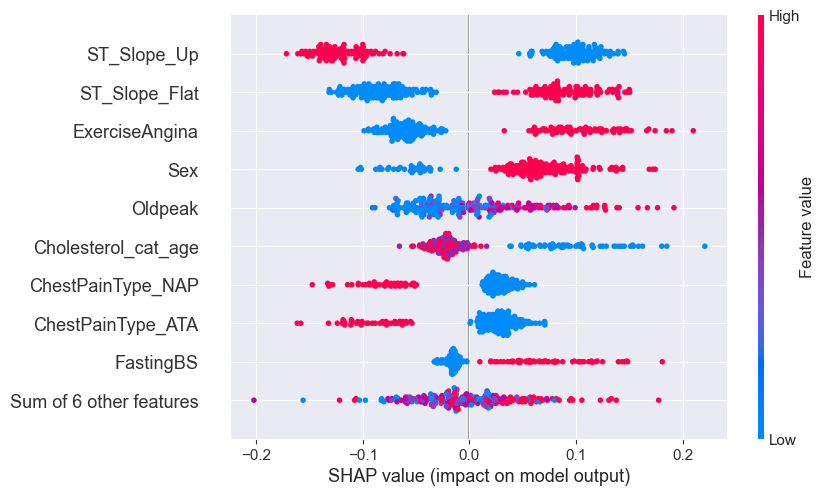

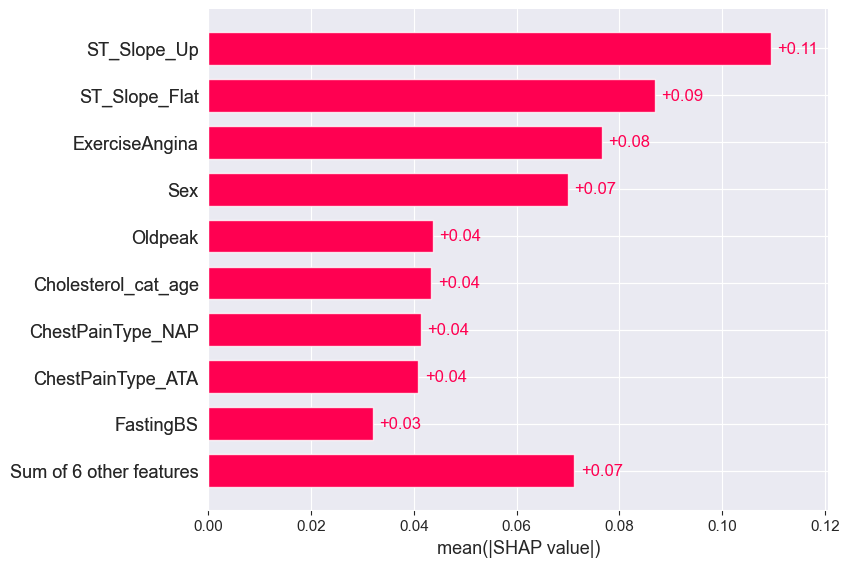

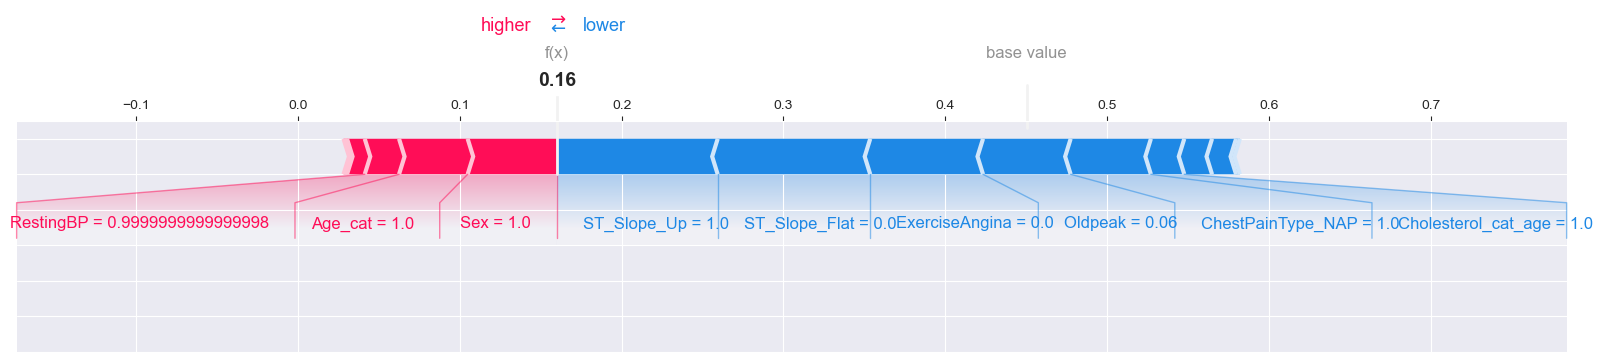

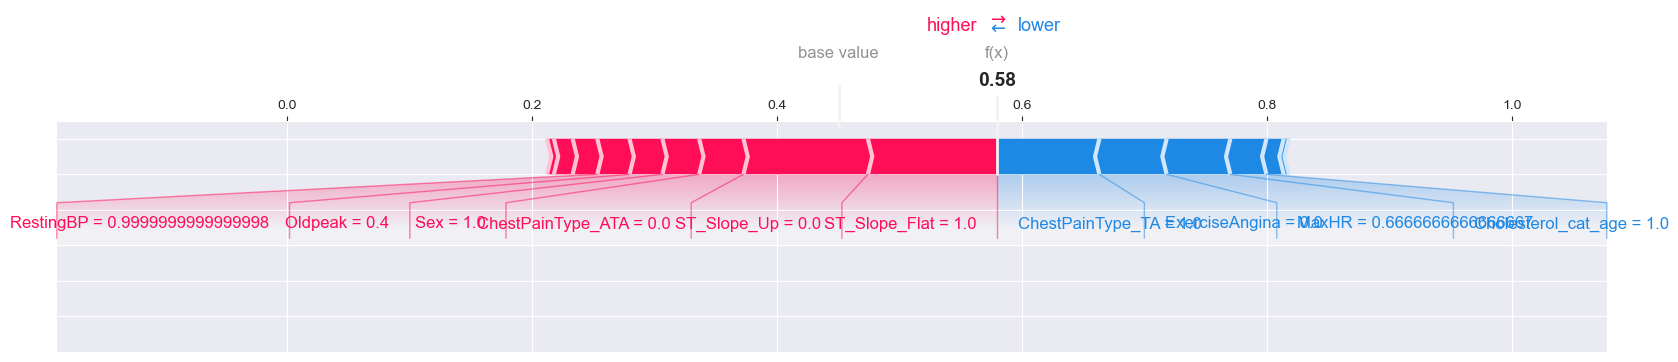

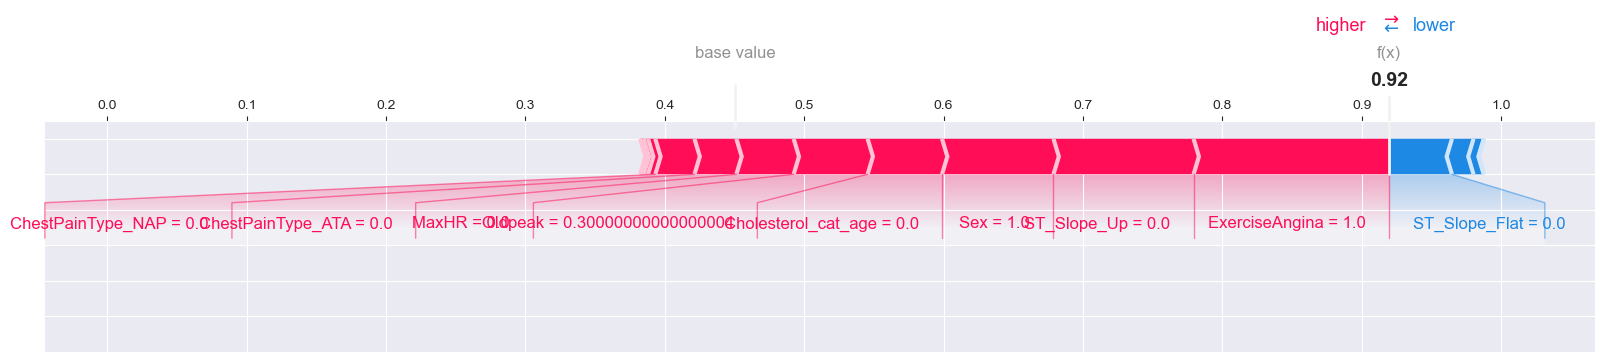

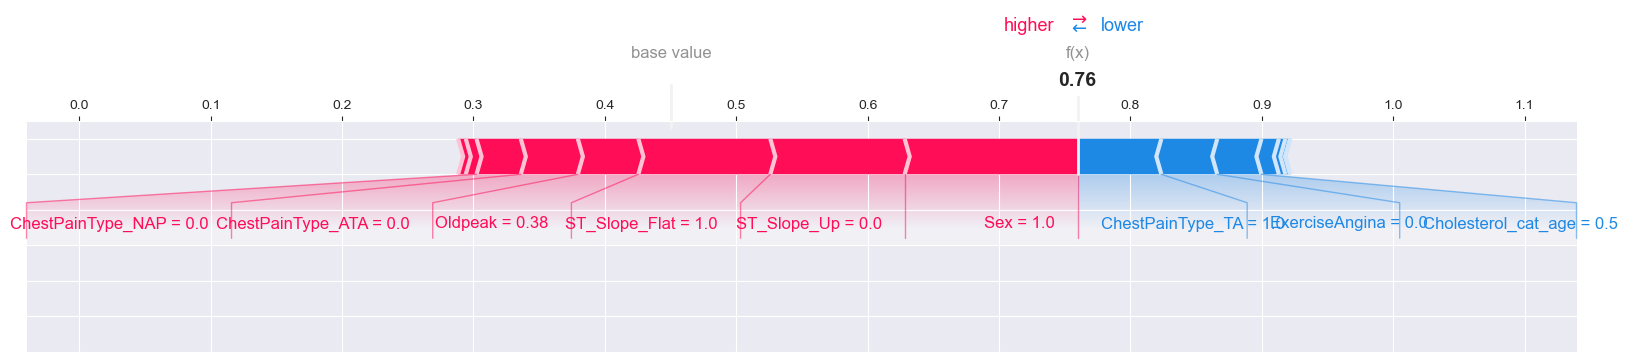

In [74]:

shap.initjs()

#SHAP-Explainer mit Trainingsdaten initialisieren (nur Features!)
explainer = shap.Explainer(best_forest_model, X_train_f_oversampled)

#SHAP-Werte für Testdaten berechnen
shap_values = explainer(X_test, check_additivity=False)

# Wichtigste Features für Klasse 1 ("krank")
shap.plots.beeswarm(shap_values[:, :, 1])

#Bar-Plot der wichtigsten Merkmale
shap.plots.bar(shap_values[:, :, 1])

# Einzelen Datenpunkter analysieren
indices = [7, 8, 9, 10]

for i, index in enumerate(indices):
    shap.plots.force(shap_values[index, :, 1], matplotlib=True)

## Smote

In [75]:
from imblearn.over_sampling import SMOTE

# SMOTE anwenden nur auf Trainingsdaten
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_f_oversampled, y_train_f_oversampled)

# 4. Ausgabe zur Kontrolle
print("Vor SMOTE:", y_train.value_counts())
print("Nach SMOTE:", y_train_resampled.value_counts())

Vor SMOTE: HeartDisease
1    376
0    312
Name: count, dtype: int64
Nach SMOTE: HeartDisease
1    606
0    606
Name: count, dtype: int64


### Random Forest mit Smote

In [76]:
print(f"Neue Verteilung im Training:\n{X_train_resampled['Sex'].value_counts()}")

# 4. Parametergrid
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# 5. GridSearchCV
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train_resampled, y_train_resampled)
best_forest_model = grid_search.best_estimator_

# 6. Bestes Modell
print("Beste Parameterkombination (grid_search.best_params_):")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBester CV-Score (grid_search.best_score_): {grid_search.best_score_:.4f}")

Neue Verteilung im Training:
Sex
1    638
0    574
Name: count, dtype: int64
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Beste Parameterkombination (grid_search.best_params_):
  bootstrap: True
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 100

Bester CV-Score (grid_search.best_score_): 0.9242


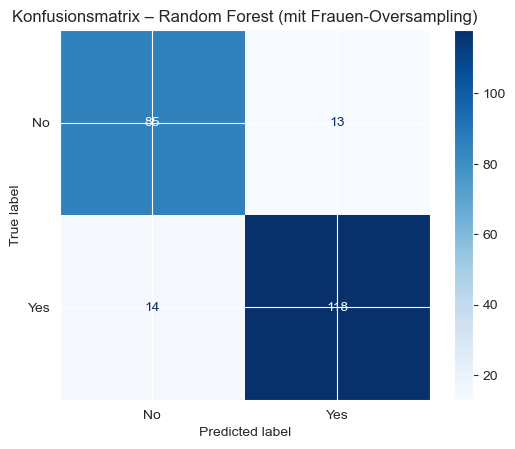

Genauigkeit: 0.8826086956521739

 Predictive Parity (Female): 0.636
 Predictive Parity (Male):   0.925
 Predictive Parity Difference: 0.289


In [77]:

# 7. Vorhersage & Evaluation
y_pred_rand = best_forest_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix – Random Forest (mit Frauen-Oversampling)')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Genauigkeit:", accuracy)

#Konfusionsmatrix nach mann und frau
# True-Labels und Vorhersagen für jede Gruppe extrahieren
y_true_female = y_test[sensitive_feature == 0]
y_pred_female = y_pred_rand[sensitive_feature == 0]

y_true_male = y_test[sensitive_feature == 1]
y_pred_male = y_pred_rand[sensitive_feature == 1]

# Precision (predictive parity) für beide Gruppen
precision_female = precision_score(y_true_female, y_pred_female)
precision_male = precision_score(y_true_male, y_pred_male)

# Predictive Parity Difference berechnen
pp_diff = abs(precision_female - precision_male)

print(f"\n Predictive Parity (Female): {precision_female:.3f}")
print(f" Predictive Parity (Male):   {precision_male:.3f}")
print(f" Predictive Parity Difference: {pp_diff:.3f}")

In [78]:

# 8. Fairness-Analyse
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "true_positive_rate": true_positive_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate  \
Sex                                                            
0    0.820513   0.636364  0.700000  0.666667        0.282051   
1    0.895288   0.925000  0.909836  0.917355        0.628272   

     false_positive_rate  true_positive_rate  
Sex                                           
0               0.137931            0.700000  
1               0.130435            0.909836  
Demographic Parity Difference: 0.346


#### TOP 10

ST_Slope_Up: 0.0409 ± 0.0103
Cholesterol_cat_age: 0.0383 ± 0.0087
FastingBS: 0.0313 ± 0.0067
ChestPainType_ATA: 0.0278 ± 0.0081
ST_Slope_Flat: 0.0261 ± 0.0159
Oldpeak: 0.0243 ± 0.0107
Sex: 0.0222 ± 0.0096
ChestPainType_NAP: 0.0196 ± 0.0073
RestingBP: 0.0178 ± 0.0074
MaxHR: 0.0117 ± 0.0062


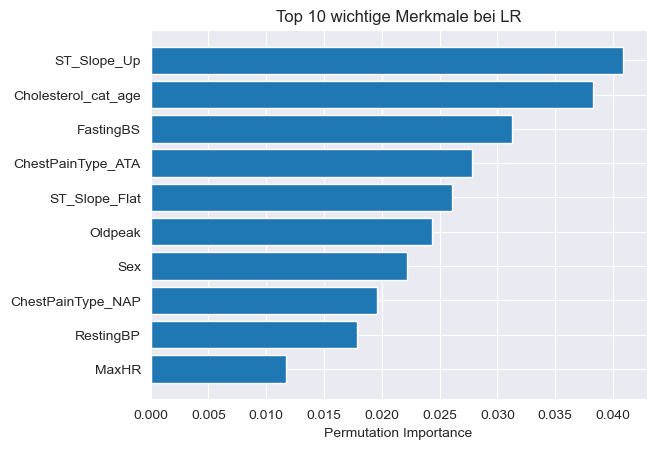

In [79]:
# Automatische Interaktion mit dem stärksten Einfluss
result = permutation_importance(best_forest_model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Sortieren der Features nach Wichtigkeit
sorted_idx = result.importances_mean.argsort()[::-1]
for i in sorted_idx[:10]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

#Plot

plt.barh(X_test.columns[sorted_idx[:10]][::-1], result.importances_mean[sorted_idx[:10]][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top 10 wichtige Merkmale bei LR")
plt.show()


#### SHAP

In [80]:
shap.initjs()

# 1. SHAP-Explainer mit Trainingsdaten initialisieren (nur Features!)
explainer = shap.Explainer(best_forest_model, X_train_resampled)

# 2. SHAP-Werte für Testdaten berechnen
shap_values = explainer(X_test)  # ergibt ein shap.Explanation-Objekt

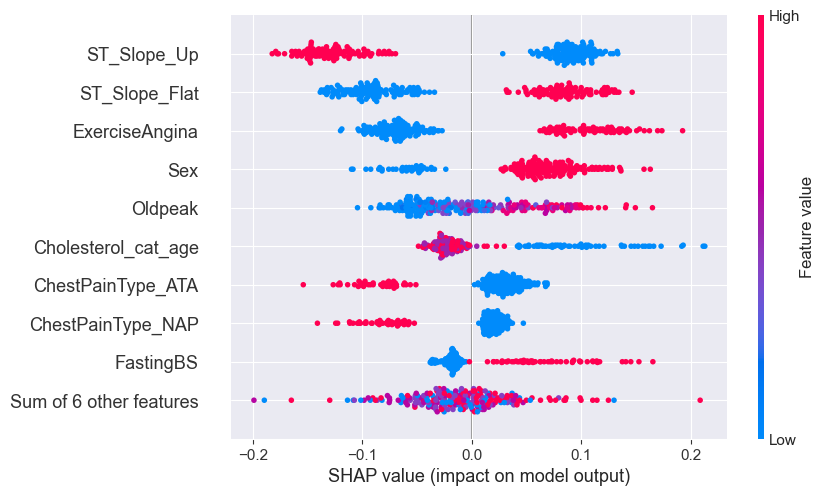

In [81]:
# 3. Übersicht: Wichtigste Features für Klasse 1 ("krank")
shap.plots.beeswarm(shap_values[:, :, 1])

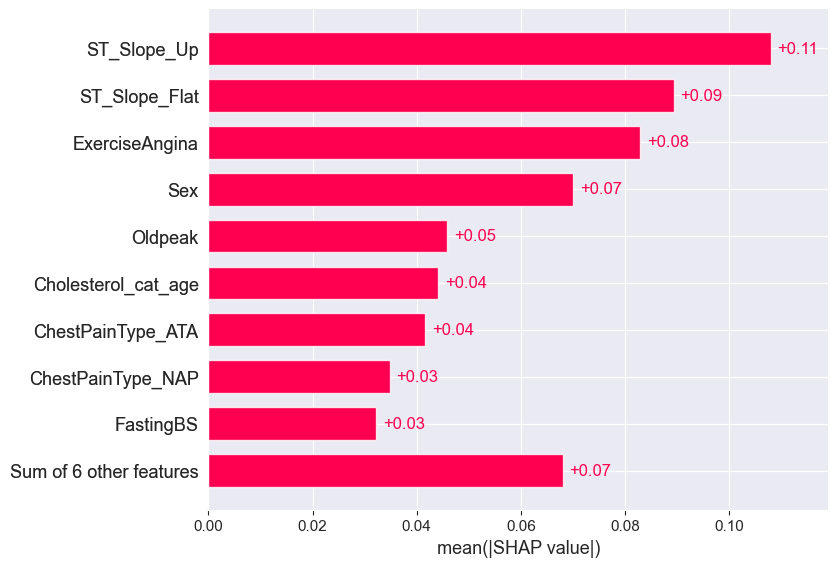

In [82]:
# 4. Alternative: Bar-Plot der wichtigsten Merkmale
shap.plots.bar(shap_values[:, :, 1])

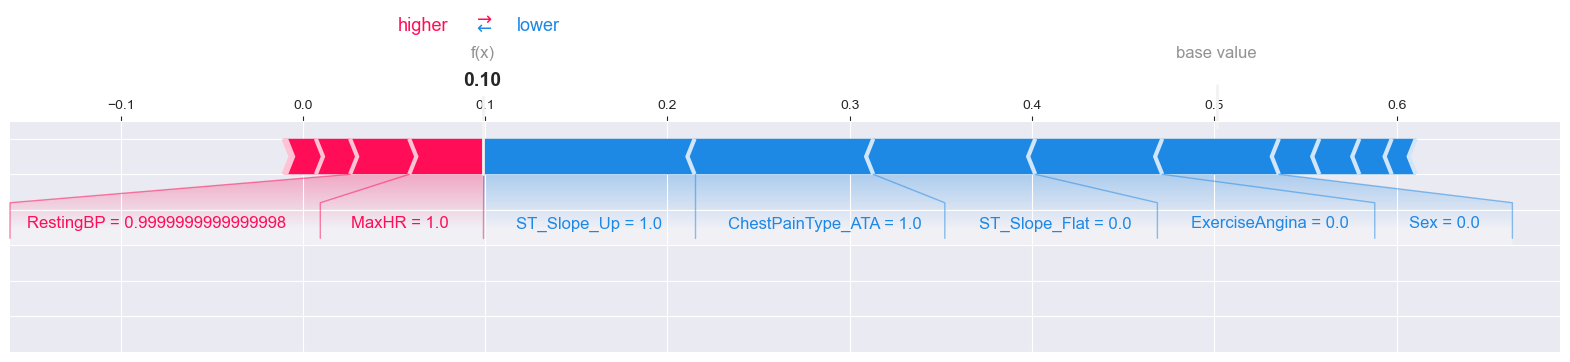

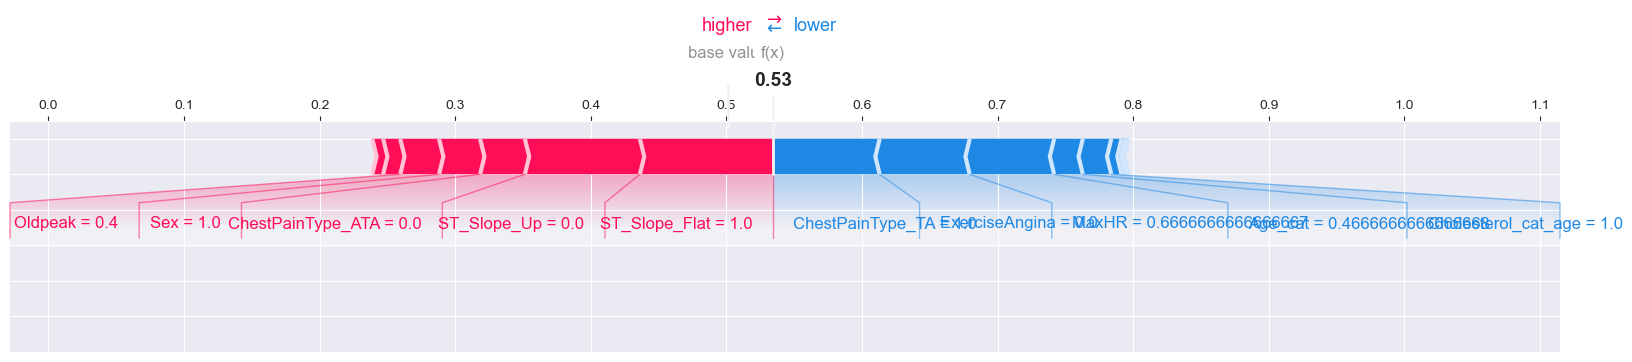

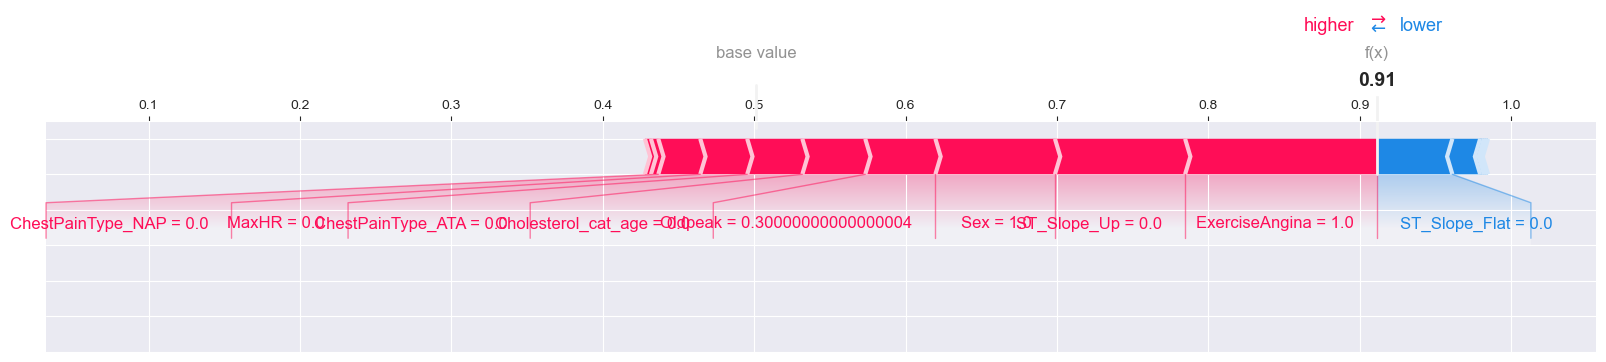

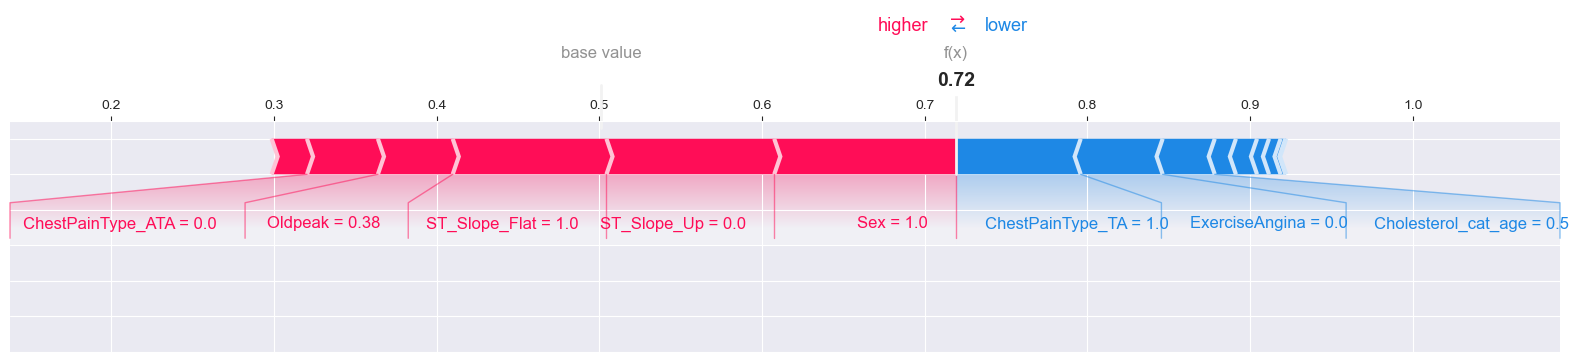

In [83]:
# 5. Einzelne Vorhersage analysieren (Index anpassen!)
indices = [0, 8, 9, 10]

for i, index in enumerate(indices):
    shap.plots.force(shap_values[index, :, 1], matplotlib=True)

### Logistic Regression mit Smote

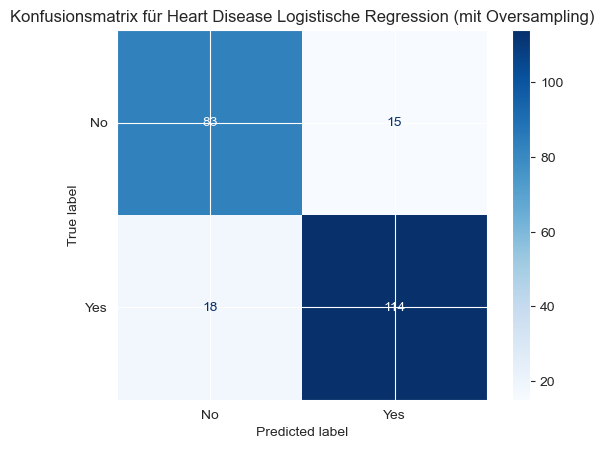

Genauigkeit: 0.8565217391304348

Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.769231   0.545455  0.600000  0.571429        0.282051
1    0.874346   0.915254  0.885246  0.900000        0.617801
Demographic Parity Difference: 0.336


In [87]:
# 4. Modell trainieren
best_lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
best_lr_model.fit(X_train_resampled, y_train_resampled)

# 5. Vorhersage und Evaluation
y_pred_log = best_lr_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Logistische Regression (mit Oversampling)')
plt.show()

accuracy = accuracy_score(y_test, y_pred_log)
print("Genauigkeit:", accuracy)

#Fairness
# Sensitives Merkmal extrahieren (Sex)
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

# MetricFrame mit Gruppenvergleich
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_log, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_log, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


#### Top 10

ChestPainType_NAP: 0.0339 ± 0.0143
ChestPainType_ATA: 0.0248 ± 0.0162
ExerciseAngina: 0.0161 ± 0.0091
FastingBS: 0.0157 ± 0.0096
Sex: 0.0143 ± 0.0108
ST_Slope_Up: 0.0109 ± 0.0115
ST_Slope_Flat: 0.0104 ± 0.0110
Oldpeak: 0.0061 ± 0.0029
ChestPainType_TA: 0.0052 ± 0.0095
Age_cat: 0.0022 ± 0.0035


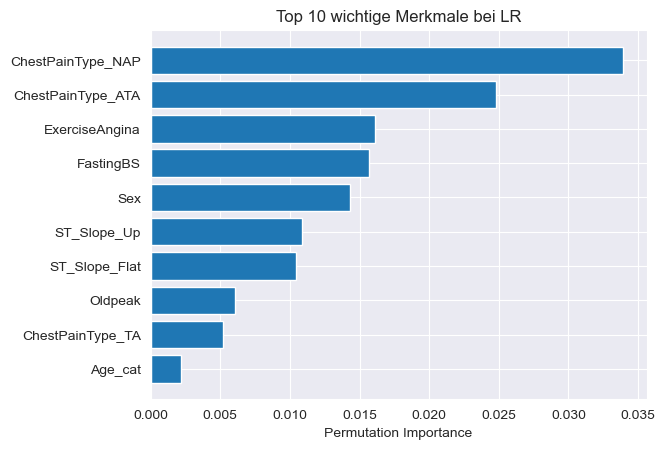

In [88]:
#Top 10 wichtigste Merkmale bei LR
result = permutation_importance(best_lr_model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Sortieren der Features nach Wichtigkeit
sorted_idx = result.importances_mean.argsort()[::-1]
for i in sorted_idx[:10]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

# Plot

plt.barh(X_test.columns[sorted_idx[:10]][::-1], result.importances_mean[sorted_idx[:10]][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top 10 wichtige Merkmale bei LR")
plt.show()

#### SHAP

In [89]:
# Neues SHAP-Explainer-Objekt (automatisch korrekt für LogisticRegression)
explainer = shap.Explainer(modelLogistic, X_train)

# SHAP-Werte berechnen – liefert ein Explanation-Objekt
shap_values = explainer(X_test)

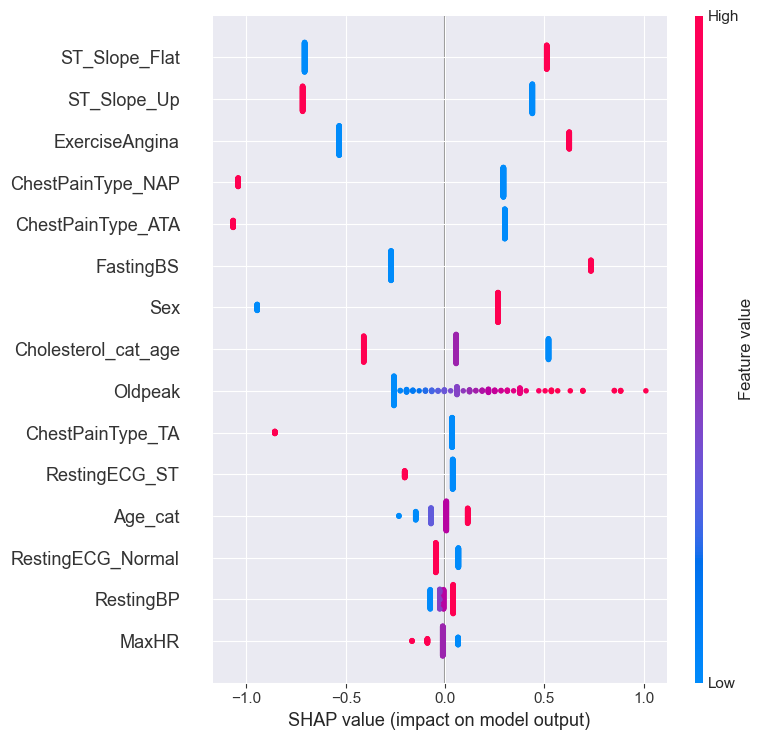

In [90]:

# Summary Plot (wichtigste Merkmale)
shap.summary_plot(shap_values, X_test)

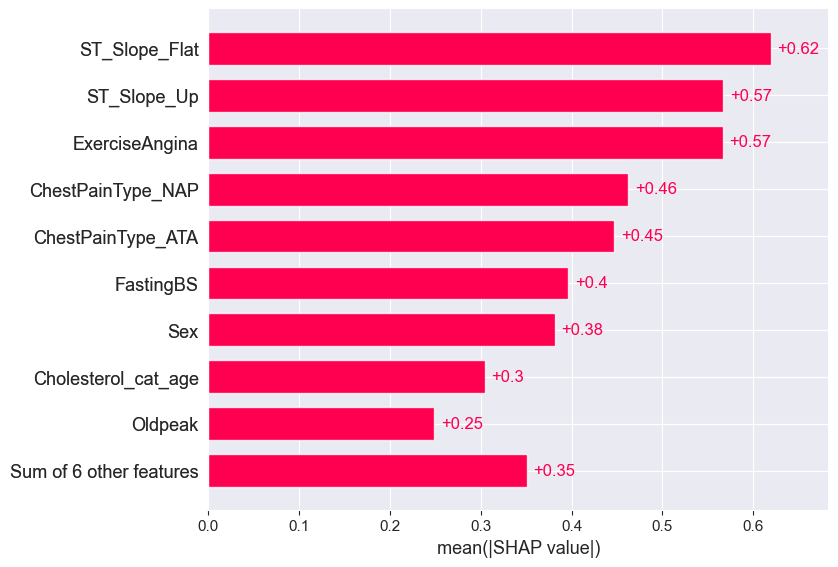

In [91]:

# Bar-Plot der durchschnittlichen Wichtigkeit
shap.plots.bar(shap_values)

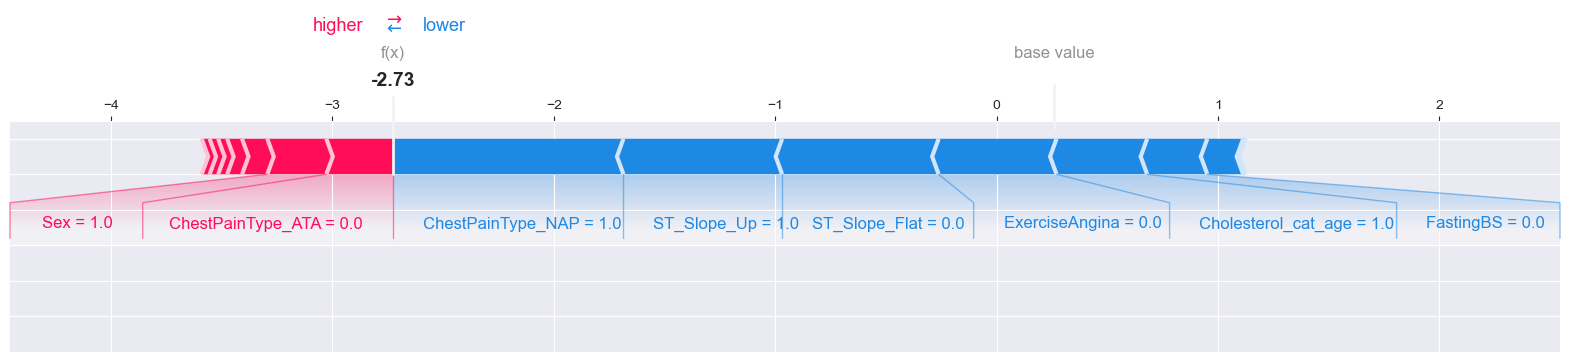

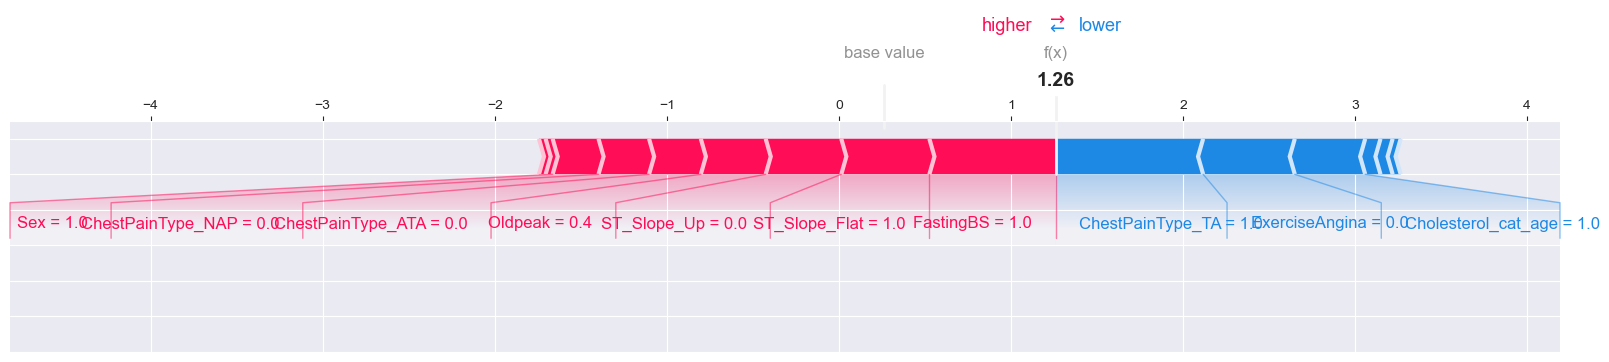

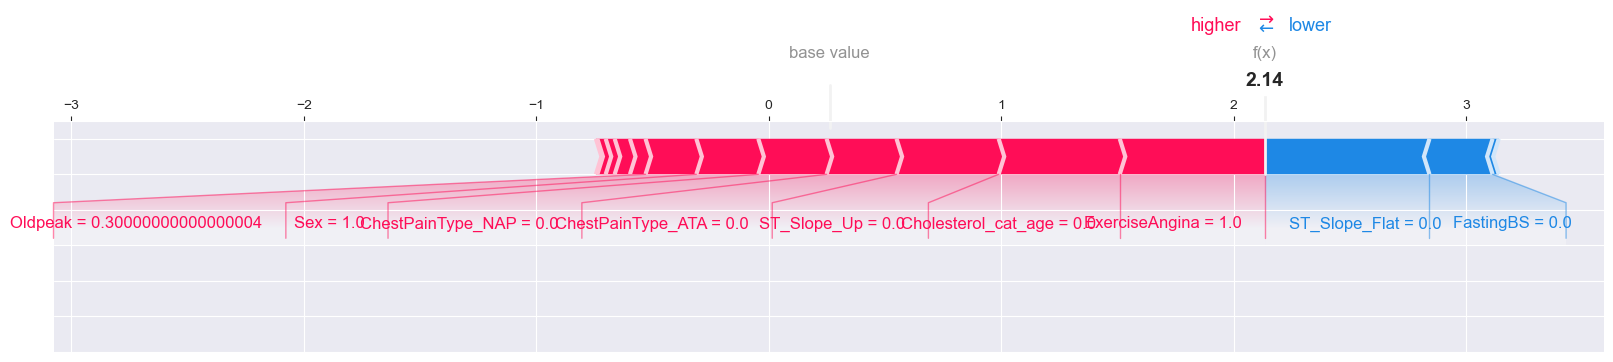

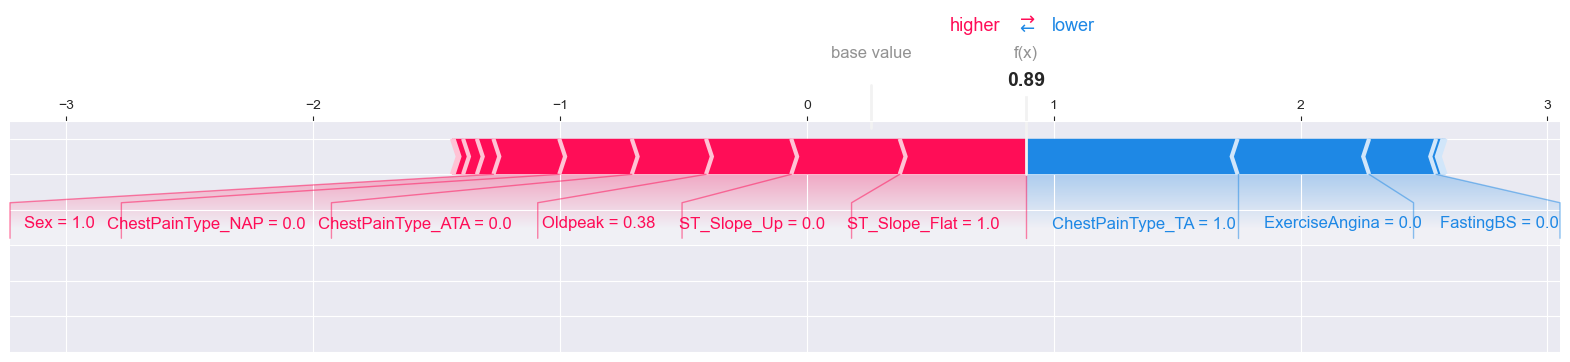

In [92]:

# Einzelne Datenpunkte analysieren
indices = [7, 8, 9, 10]
for index in indices:
    shap.plots.force(shap_values[index], matplotlib=True)

## Stacking LR, RF

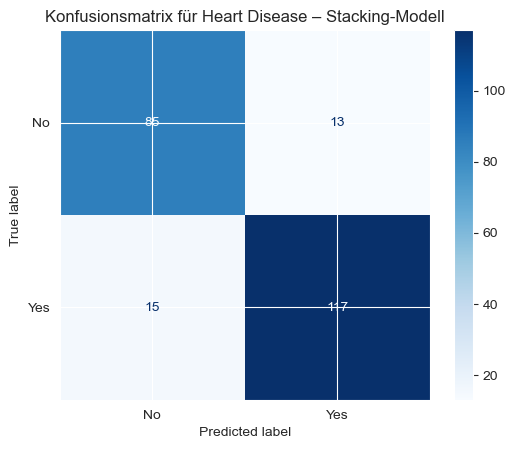

Genauigkeit (Stacking): 0.8782608695652174

Fairness-Analyse nach 'Sex' (Stacking):
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.794872      0.600  0.600000  0.600000        0.256410
1    0.895288      0.925  0.909836  0.917355        0.628272
Demographic Parity Difference: 0.372


In [93]:
# Basismodelle (schon trainiert mit SMOTE)
estimators = [
    ('rf', best_forest_model),
    ('lr', best_lr_model),
]

# Meta-Modell: Logistische Regression
final_estimator = LogisticRegression(max_iter=1000, class_weight='balanced')

# Stacking-Classifier
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    passthrough=False,  # wenn True werden auch Original-Features aus dem Meta-Modell übergeben
    n_jobs=-1
)
# Stacking-Modell (smote Trainingsdaten)
stacked_model.fit(X_train_resampled, y_train_resampled)

#  Vorhersage auf Testdaten
y_pred_stack = stacked_model.predict(X_test)

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease – Stacking-Modell')
plt.show()

accuracy = accuracy_score(y_test, y_pred_stack)
print("Genauigkeit (Stacking):", accuracy)

# Fairness-Analyse
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}
# nach Geschlecht
frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_stack, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex' (Stacking):")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_stack, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")

## Stacking LR, RF und XG Boost

### XG Boost

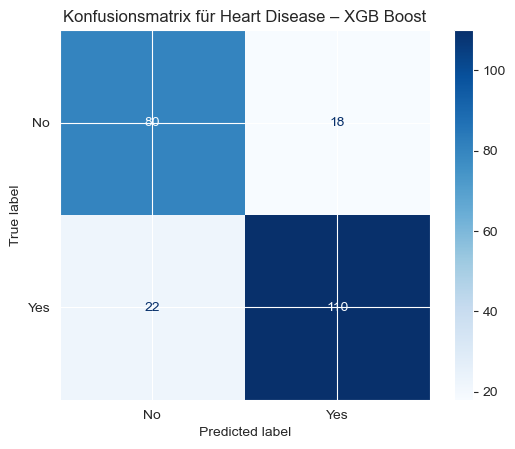

Genauigkeit (Stacking): 0.8782608695652174

Fairness-Analyse nach 'Sex' (XGB Boost):
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.794872      0.600  0.600000  0.600000        0.256410
1    0.895288      0.925  0.909836  0.917355        0.628272
Demographic Parity Difference: 0.372


In [94]:
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease – XGB Boost')
plt.show()

accuracy = accuracy_score(y_test, y_pred_stack)
print("Genauigkeit (Stacking):", accuracy)

# Fairness-Analyse
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}
# nach Geschlecht
frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_stack, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex' (XGB Boost):")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_stack, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")

### Stacking

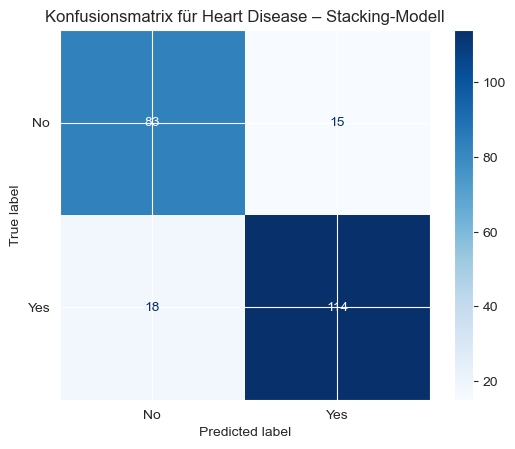

Genauigkeit (Stacking): 0.8565217391304348

Fairness-Analyse nach 'Sex' (Stacking):
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.769231   0.545455  0.600000  0.571429        0.282051
1    0.874346   0.915254  0.885246  0.900000        0.617801
Demographic Parity Difference: 0.336


In [95]:

estimators = [
    ('rf', best_forest_model),
    ('lr', best_lr_model),
    ('xgb', xgb_model)
]

# Meta-Modell: Logistische Regression
final_estimator = LogisticRegression(max_iter=1000, class_weight='balanced')

# Stacking-Classifier
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    passthrough=False,  # wenn True werden auch Original-Features aus dem Meta-Modell übergeben
    n_jobs=-1
)
# Stacking-Modell (smote Trainingsdaten)
stacked_model.fit(X_train_resampled, y_train_resampled)

#  Vorhersage auf Testdaten
y_pred_stack = stacked_model.predict(X_test)

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease – Stacking-Modell')
plt.show()

accuracy = accuracy_score(y_test, y_pred_stack)
print("Genauigkeit (Stacking):", accuracy)

# Fairness-Analyse
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}
# nach Geschlecht
frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_stack, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex' (Stacking):")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_stack, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")

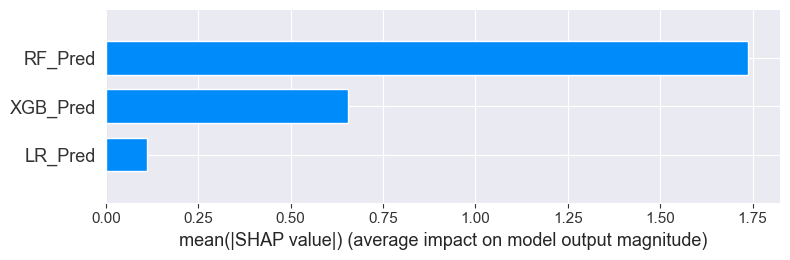

In [96]:
# Vorhersagen der Base-Modelle auf den Testdaten (Wahrscheinlichkeiten)
rf_pred = best_forest_model.predict_proba(X_test)[:, 1]
lr_pred = best_lr_model.predict_proba(X_test)[:, 1]
xgb_pred = xgb_model.predict_proba(X_test)[:, 1]

# Kombiniere zu Meta-Feature-Matrix
meta_features = np.column_stack((rf_pred, lr_pred, xgb_pred))

# SHAP Explainer für das Meta-Modell
explainer = shap.Explainer(stacked_model.final_estimator_, meta_features)

# SHAP-Werte berechnen
shap_values = explainer(meta_features)

# Feature-Namen manuell setzen
feature_names = ["RF_Pred", "LR_Pred", "XGB_Pred"]

# Summary-Plot
shap.summary_plot(shap_values, features=meta_features, feature_names=feature_names, plot_type="bar")
